In [ ]:
# !pip install category_encoders

# Importing the Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,LabelEncoder,OneHotEncoder
from sklearn.metrics import accuracy_score, f1_score, roc_curve
from scipy.spatial.distance import pdist,squareform
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics.pairwise import rbf_kernel
from sklearn import neighbors
from sklearn.svm import SVC
from sklearn.utils import shuffle

import time
import pickle
import Orange 
from math import floor
from scipy import sparse
from scipy.stats import friedmanchisquare
import seaborn as sns

In [ ]:
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Dense,LeakyReLU,BatchNormalization

#### Setting the numpy random seed so that the values do not change every time I run the code

In [2]:
np.random.seed(42)

# Helper Functions

### Function to plot ROC

In [3]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=4, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

### Function to print Evaluation Metrics

In [4]:
def PerformanceEvaluation(y_true,y_pred,start_time,end_time,y_pred_prob=None):
    print("\n\tPERFORMANCE EVALUATION")
    print("\nRUNNING TIME: {:.4f}".format(end_time-start_time))
    print("\nACCURACY: {:.2f}".format(accuracy_score(y_true,y_pred)))
    print("\nF1 SCORE: {:.2f}".format(f1_score(y_true,y_pred)))
    if y_pred_prob is None:
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    else:
        tpr, fpr, thresholds = roc_curve(y_true, y_pred_prob[:,0])
    plt.figure(figsize=(8, 6))
    plot_roc_curve(fpr, tpr)
    plt.show()

### Function to Unlabel Data

In [5]:
def Unlabel(X,y,unlabel_percent = 0.5,split=True):
    # If split=True I split the labelled and unlabelled data
    if split:
        if unlabel_percent <= 0:
            return (X,None,y)
        else:
            X_lab,X_ulab,y_lab,y_ulab = train_test_split(X,y,test_size = unlabel_percent,stratify=y,random_state=42)
            return (X_lab,X_ulab,y_lab)
    # If split=False then I unlabel data in place
    else:
        if unlabel_percent <= 0:
            return (X,y)
        else:
            #Marking some percentage of the data as unlabelled data
            y = y.astype(int)
            shuffle_index = np.random.permutation(floor(len(X)*unlabel_percent))
            y[shuffle_index] = -1
            X, y = shuffle(X, y, random_state=42)
            return (X,y)

# Preprocessing Dataset 1

In [6]:
dataset1 = pd.read_csv('data/online_shoppers_intention.csv')

Dropping any default value columns

In [ ]:
dataset1 = dataset1.loc[:,dataset1.apply(pd.Series.nunique) != 1]

#### Checking for NaN/Infinity Values 

In [ ]:
dataset1.isna().values.any() or dataset1.isin([np.inf, -np.inf]).values.any()

False

#### Converting Weekend and Revenue to Int

In [ ]:
dataset1.Weekend = dataset1.Weekend.astype(int)
dataset1.Revenue = dataset1.Revenue.astype(int)

### One Hot Encoding Categorical Data

In [ ]:
cat_col_names = ["OperatingSystems","Browser","Region","TrafficType","VisitorType","Weekend"]

In [ ]:
import category_encoders as ce

encoder=ce.OneHotEncoder(cols=cat_col_names,handle_unknown='value',return_df=True,use_cat_names=True)
dataset1 = encoder.fit_transform(dataset1)

### Cyclic Method for Month

In [ ]:
le = LabelEncoder()
dataset1['Month'] = le.fit_transform(dataset1['Month'])

In [ ]:
dataset1['Sin_Month'] = np.sin(2*np.pi*dataset1['Month'] / max(dataset1['Month']))
dataset1['Cos_Month'] = np.cos(2*np.pi*dataset1['Month'] / max(dataset1['Month']))

In [ ]:
dataset1.drop(['Month'],inplace=True,axis=1)

In [ ]:
 dataset1.head()

Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ProductRelated_Duration  \
0                     0.0               1                 0.000000   
1                     0.0               2                64.000000   
2                     0.0               1                 0.000000   
3                     0.0               2                 2.666667   
4                     0.0              10               627.500000   

   BounceRates  ExitRates  PageValues  SpecialDay  ...  TrafficType_17.0  \
0         0.20       0.20         0.0         0.0  ...                 0   
1         0.00       0.10         0.0         0.0  ...                 0   
2         0.20       0.20         0.0         0.0  ...                 0   
3         0.05       0.14         0.0         0.0  ...                 0   
4         0.02       0.05         0.0         0.0  ...                 0   

   TrafficType_20.0  VisitorType_Returning_Visitor  VisitorType_New_Visitor  \
0                 0                              1                        0   
1                 0                              1                        0   
2                 0                              1                        0   
3                 0                              1                        0   
4                 0                              1                        0   

   VisitorType_Other  Weekend_0.0  Weekend_1.0  Revenue  Sin_Month  Cos_Month  
0                  0            1            0        0   0.984808   0.173648  
1                  0            1            0        0   0.984808   0.173648  
2                  0            1            0        0   0.984808   0.173648  
3                  0            1            0        0   0.984808   0.173648  
4                  0            0            1        0   0.984808   0.173648  

[5 rows x 68 columns]

### Feature Selection
- For this step I first eliminate the redundant features.
- Since BounceRate and ExitRate have a high correlation with each other (>0.85), I will remove one.
- Since ProductRelated and ProductRelatedDuration have a high correlation with each other (>0.85), I will remove one.
- Between BounceRate and ExitRate, I remove BounceRate as ExitRate correlates with Revenue (y target) more.
- Between ProductRelated and ProductRelatedDuration, I remove ProductRelatedDuration as ProductRelated correlates with Revenue (y target) more.

<AxesSubplot:>

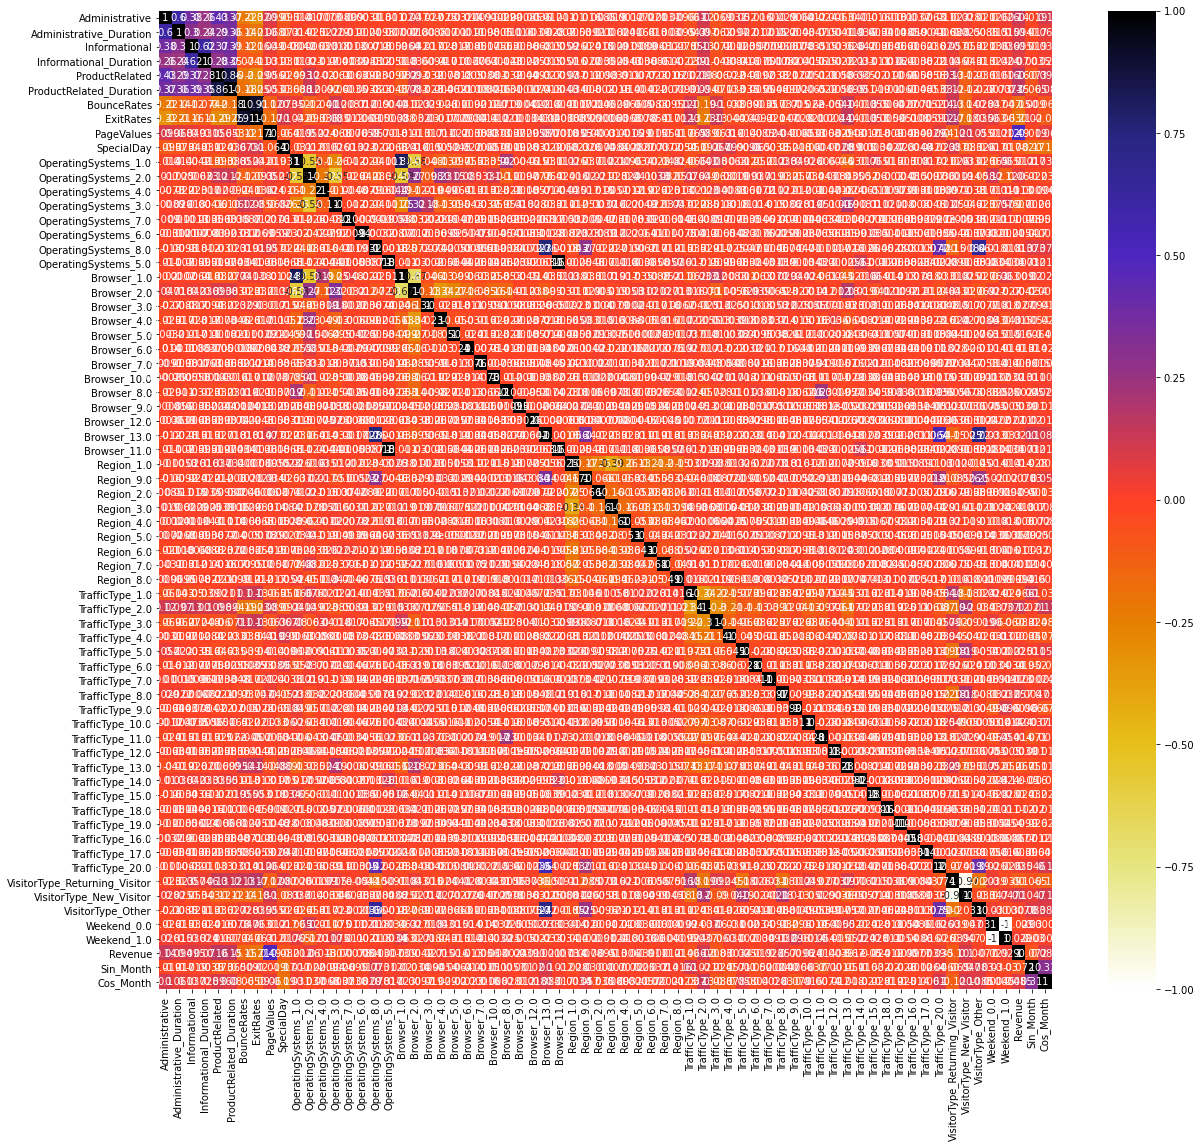

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,18))
cor = dataset1.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)

#### Dropping Redundant Features

In [ ]:
dataset1.drop(["BounceRates","ProductRelated_Duration"],axis=1,inplace=True)

#### Dropping features with high degree of correlation with each other (redundant features)

In [ ]:
# Create correlation matrix
corr_matrix = dataset1.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Drop features 
dataset1.drop(to_drop, axis=1, inplace=True)

In [ ]:
dataset1.shape

(12330, 63)

### Ranking the Features based on Correlation with Revenue

In [ ]:
corr = dataset1.corr()["Revenue"][1:]
abs_corr = abs(corr)
abs_corr = abs_corr.sort_values(ascending=False)

In [ ]:
pd.set_option('display.max_rows', 200) # To display the rankings of all the features
print("Total Number of Rows :",len(abs_corr))
print(abs_corr)

Total Number of Rows : 62
Revenue                          1.000000
PageValues                       0.492569
ExitRates                        0.207071
ProductRelated                   0.158538
TrafficType_2.0                  0.116347
VisitorType_Returning_Visitor    0.103843
Informational                    0.095200
Administrative_Duration          0.093587
Cos_Month                        0.085405
TrafficType_3.0                  0.082808
SpecialDay                       0.082305
Sin_Month                        0.072082
OperatingSystems_3.0             0.070472
Informational_Duration           0.070345
TrafficType_13.0                 0.067310
TrafficType_1.0                  0.065901
OperatingSystems_2.0             0.060040
TrafficType_8.0                  0.057167
TrafficType_20.0                 0.034540
Weekend_0.0                      0.029295
Browser_3.0                      0.027451
TrafficType_5.0                  0.024609
TrafficType_10.0                 0.024354
TrafficT

Here I have a threshold of <b>0.02</b>, removing all rows that fall below this threshold.

In [ ]:
to_drop = abs(dataset1.corr()['Revenue'][abs(dataset1.corr()['Revenue'])<0.05]).index.tolist()

In [ ]:
dataset1.drop(to_drop,axis=1,inplace=True)

In [ ]:
dataset1.head()

Administrative  Administrative_Duration  Informational  \
0               0                      0.0              0   
1               0                      0.0              0   
2               0                      0.0              0   
3               0                      0.0              0   
4               0                      0.0              0   

   Informational_Duration  ProductRelated  ExitRates  PageValues  SpecialDay  \
0                     0.0               1       0.20         0.0         0.0   
1                     0.0               2       0.10         0.0         0.0   
2                     0.0               1       0.20         0.0         0.0   
3                     0.0               2       0.14         0.0         0.0   
4                     0.0              10       0.05         0.0         0.0   

   OperatingSystems_2.0  OperatingSystems_3.0  TrafficType_1.0  \
0                     0                     0                1   
1                     1                     0                0   
2                     0                     0                0   
3                     0                     1                0   
4                     0                     1                0   

   TrafficType_2.0  TrafficType_3.0  TrafficType_8.0  TrafficType_13.0  \
0                0                0                0                 0   
1                1                0                0                 0   
2                0                1                0                 0   
3                0                0                0                 0   
4                0                0                0                 0   

   VisitorType_Returning_Visitor  Revenue  Sin_Month  Cos_Month  
0                              1        0   0.984808   0.173648  
1                              1        0   0.984808   0.173648  
2                              1        0   0.984808   0.173648  
3                              1        0   0.984808   0.173648  
4                              1        0   0.984808   0.173648

### Splitting the dataset into X1 and y1

In [ ]:
X_train1 = dataset1.loc[:,dataset1.columns!='Revenue']
y_train1 = dataset1.Revenue

### Train-Test Split

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train1, y_train1, stratify = y_train1,test_size = 0.3)

### Normalize the Data

In [ ]:
scaler = StandardScaler()
X_train1.iloc[:,0:8] = scaler.fit_transform(X_train1.iloc[:,0:8])
X_test1.iloc[:,0:8] = scaler.transform(X_test1.iloc[:,0:8])

# Preprocessing Dataset 2

In [ ]:
dataset2 = pd.read_csv('data/marketing_campaign.csv', delimiter='\t')

#### Processing Teenhome

In [ ]:
dataset2["Teenhome"] = (dataset2['Teenhome']>0)

Dropping any default value columns

In [ ]:
dataset2 = dataset2.loc[:,dataset2.apply(pd.Series.nunique) != 1]

#### Checking for NaN/Infinity Values 

In [ ]:
dataset2.isna().values.any()

True

In [ ]:
dataset2.isin([np.inf, -np.inf]).values.any()

False

#### Determining the Column with Missing Values

In [ ]:
percent_col = dataset2.isna().sum()/(len(dataset2))*100

print(f"Column with highest amount of missings contains {percent_col.max()} % missings.")
print(f"Columns with Missing Values are {dataset2.loc[:, dataset2.isnull().any()].columns}")

Column with highest amount of missings contains 1.0714285714285714 % missings.
Columns with Missing Values are Index(['Income'], dtype='object')


<b>Since there is only 1% missing, we can drop those Columns<br></b>
Imputing the values

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
dataset2['Income'] = imputer.fit_transform(dataset2[['Income']]).ravel()

## Categorical Data
### Ordinal Encoder

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

oe = OrdinalEncoder()
dataset2[["Education"]] = oe.fit_transform(dataset2[["Education"]])

### One Hot Encoder

In [ ]:
import category_encoders as ce

encoder=ce.OneHotEncoder(cols=["Marital_Status"],handle_unknown='value',return_df=True,use_cat_names=True)
dataset2 = encoder.fit_transform(dataset2)

In [ ]:
dataset2.head()

ID  Year_Birth  Education  Marital_Status_Single  \
0  5524        1957        2.0                      1   
1  2174        1954        2.0                      1   
2  4141        1965        2.0                      0   
3  6182        1984        2.0                      0   
4  5324        1981        4.0                      0   

   Marital_Status_Together  Marital_Status_Married  Marital_Status_Divorced  \
0                        0                       0                        0   
1                        0                       0                        0   
2                        1                       0                        0   
3                        1                       0                        0   
4                        0                       1                        0   

   Marital_Status_Widow  Marital_Status_Alone  Marital_Status_Absurd  ...  \
0                     0                     0                      0  ...   
1                     0                     0                      0  ...   
2                     0                     0                      0  ...   
3                     0                     0                      0  ...   
4                     0                     0                      0  ...   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                  7             0   
1                    1                  2                  5             0   
2                    2                 10                  4             0   
3                    0                  4                  6             0   
4                    3                  6                  5             0   

  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  
0            0             0             0             0         0         1  
1            0             0             0             0         0         0  
2            0             0             0             0         0         0  
3            0             0             0             0         0         0  
4            0             0             0             0         0         0  

[5 rows x 34 columns]

### Handling DateTime
- First I seperate the Dt_Customer Field into Day, Month and Year Fields
- I then apply the cyclic method on Day and Month

<b>Seperating Year, Month and Day</b>

In [ ]:
dataset2['Dt_Customer'] = pd.to_datetime(dataset2['Dt_Customer'])
dataset2['Dt_Customer_Year'] = dataset2['Dt_Customer'].dt.year
dataset2['Dt_Customer_Month'] = dataset2['Dt_Customer'].dt.month
dataset2['Dt_Customer_Day'] = dataset2['Dt_Customer'].dt.day
dataset2.drop('Dt_Customer',inplace=True,axis=1)

<b>Applying Cyclic Method to Month and Day</b>

In [ ]:
# Taking Sin and Cos of Month
dataset2['Sin_Dt_Customer_Month'] = np.sin(2*np.pi*dataset2['Dt_Customer_Month'] / max(dataset2['Dt_Customer_Month']))
dataset2['Cos_Dt_Customer_Month'] = np.cos(2*np.pi*dataset2['Dt_Customer_Month'] / max(dataset2['Dt_Customer_Month']))

#Droping the Month Column
dataset2.drop(['Dt_Customer_Month'],inplace=True,axis=1)

In [ ]:
# Taking Sin and Cos of Day
dataset2['Sin_Dt_Customer_Day'] = np.sin(2*np.pi*dataset2['Dt_Customer_Day'] / max(dataset2['Dt_Customer_Day']))
dataset2['Cos_Dt_Customer_Day'] = np.cos(2*np.pi*dataset2['Dt_Customer_Day'] / max(dataset2['Dt_Customer_Day']))

#Droping the Day Column
dataset2.drop(['Dt_Customer_Day'],inplace=True,axis=1)

### Normalize the Data

In [ ]:
scaler = StandardScaler()

data_to_norm = ['Year_Birth','Income','Recency','MntWines','MntFruits','MntMeatProducts','MntFishProducts','MntSweetProducts','MntGoldProds',\
                'NumDealsPurchases','NumWebPurchases','NumCatalogPurchases','NumStorePurchases','NumWebVisitsMonth']

dataset2[data_to_norm] = scaler.fit_transform(dataset2[data_to_norm])

### Feature Selection

<AxesSubplot:>

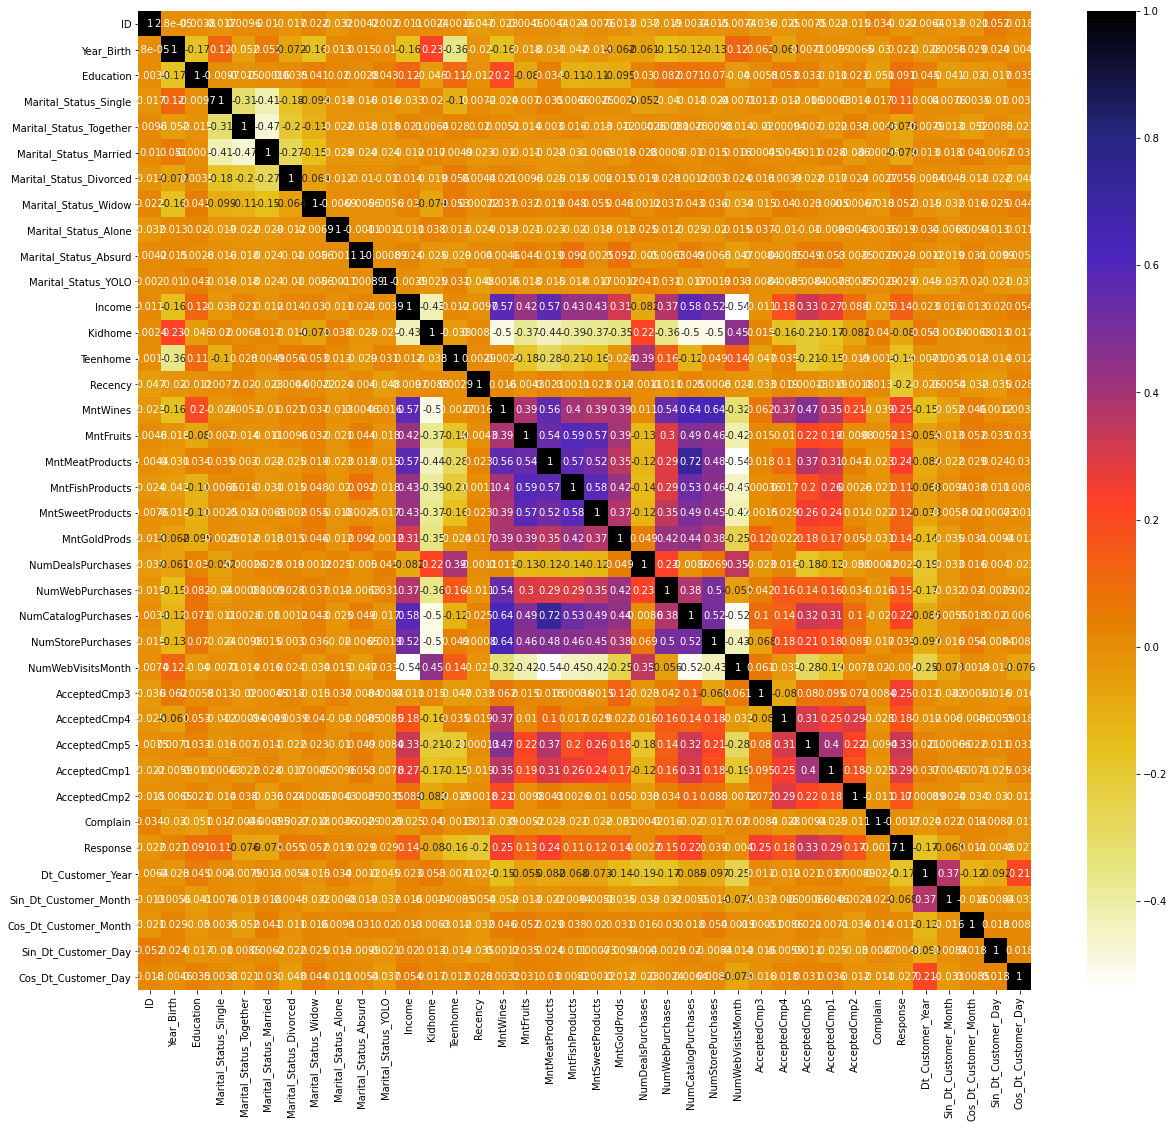

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,18))
cor = dataset2.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)

#### Dropping features with high degree of correlation with each other (redundant features)

In [ ]:
# Create correlation matrix
corr_matrix = dataset2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

# Drop features 
dataset2.drop(to_drop, axis=1, inplace=True)

In [ ]:
dataset2.shape

(2240, 38)

### Ranking the Features based on Correlation with Revenue

In [ ]:
corr = dataset2.corr()["Teenhome"][1:]
abs_corr = abs(corr)
abs_corr = abs_corr.sort_values(ascending=False)

In [ ]:
pd.set_option('display.max_rows', 200) # To display the rankings of all the features
print("Total Number of Rows :",len(abs_corr))
print(abs_corr)

Total Number of Rows : 37
Teenhome                   1.000000
NumDealsPurchases          0.394173
Year_Birth                 0.357522
MntMeatProducts            0.275840
MntFishProducts            0.210868
AcceptedCmp5               0.205445
MntFruits                  0.182316
MntSweetProducts           0.164644
Response                   0.161356
NumWebPurchases            0.157645
AcceptedCmp1               0.147731
NumWebVisitsMonth          0.143069
NumCatalogPurchases        0.116574
Education                  0.109601
Marital_Status_Single      0.102019
Marital_Status_Divorced    0.055518
Marital_Status_Widow       0.052988
NumStorePurchases          0.048658
AcceptedCmp3               0.047238
Kidhome                    0.037543
AcceptedCmp4               0.035144
Marital_Status_YOLO        0.030926
Marital_Status_Absurd      0.028896
Marital_Status_Together    0.028224
MntGoldProds               0.024489
AcceptedCmp2               0.019360
Sin_Dt_Customer_Day        0.013754
Ma

Here I have a threshold of <b>0.01</b>, removing all rows that fall below this threshold.

In [ ]:
to_drop = abs(dataset2.corr()['Teenhome'][abs(dataset2.corr()['Teenhome'])<0.01]).index.tolist()

In [ ]:
dataset2.drop(to_drop,axis=1,inplace=True)

In [ ]:
dataset2.head()

Year_Birth  Education  Marital_Status_Single  Marital_Status_Together  \
0   -0.985345        2.0                      1                        0   
1   -1.235733        2.0                      1                        0   
2   -0.317643        2.0                      0                        1   
3    1.268149        2.0                      0                        1   
4    1.017761        4.0                      0                        0   

   Marital_Status_Divorced  Marital_Status_Widow  Marital_Status_Alone  \
0                        0                     0                     0   
1                        0                     0                     0   
2                        0                     0                     0   
3                        0                     0                     0   
4                        0                     0                     0   

   Marital_Status_Absurd  Marital_Status_YOLO    Income  ...  \
0                      0                    0  0.250276  ...   
1                      0                    0 -0.213095  ...   
2                      0                    0  0.779692  ...   
3                      0                    0 -0.987004  ...   
4                      0                    0  0.256366  ...   

   NumWebVisitsMonth  AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  \
0           0.693904             0             0             0             0   
1          -0.130463             0             0             0             0   
2          -0.542647             0             0             0             0   
3           0.281720             0             0             0             0   
4          -0.130463             0             0             0             0   

   AcceptedCmp2  Response  Cos_Dt_Customer_Month  Sin_Dt_Customer_Day  \
0             0         1              -0.500000             0.968077   
1             0         0              -0.500000             0.571268   
2             0         0              -0.500000            -0.897805   
3             0         0               0.500000             0.394356   
4             0         0               0.866025            -0.651372   

   Cos_Dt_Customer_Day  
0            -0.250653  
1             0.820763  
2            -0.440394  
3             0.918958  
4            -0.758758  

[5 rows x 31 columns]

### Splitting the dataset into X2 and y2

In [ ]:
X_train2 = dataset2.loc[:,dataset2.columns!='Teenhome']
y_train2 = dataset2.Teenhome

### Train - Test Split

In [ ]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_train2, y_train2, stratify = y_train2,test_size = 0.3)

# Preprocessing Dataset 3

In [ ]:
dataset3 = pd.read_csv('data/heart.csv')

Dropping any default value columns

In [ ]:
dataset3 = dataset3.loc[:,dataset3.apply(pd.Series.nunique) != 1]

#### Checking for NaN/Infinity Values 

In [ ]:
dataset3.isna().values.any()

False

In [ ]:
dataset3.isin([np.inf, -np.inf]).values.any()

False

### Normalize the Data

In [ ]:
scaler = StandardScaler()

data_to_norm = ['age','trestbps','chol','thalach','oldpeak']

dataset3[data_to_norm] = scaler.fit_transform(dataset3[data_to_norm])

### Feature Selection

<AxesSubplot:>

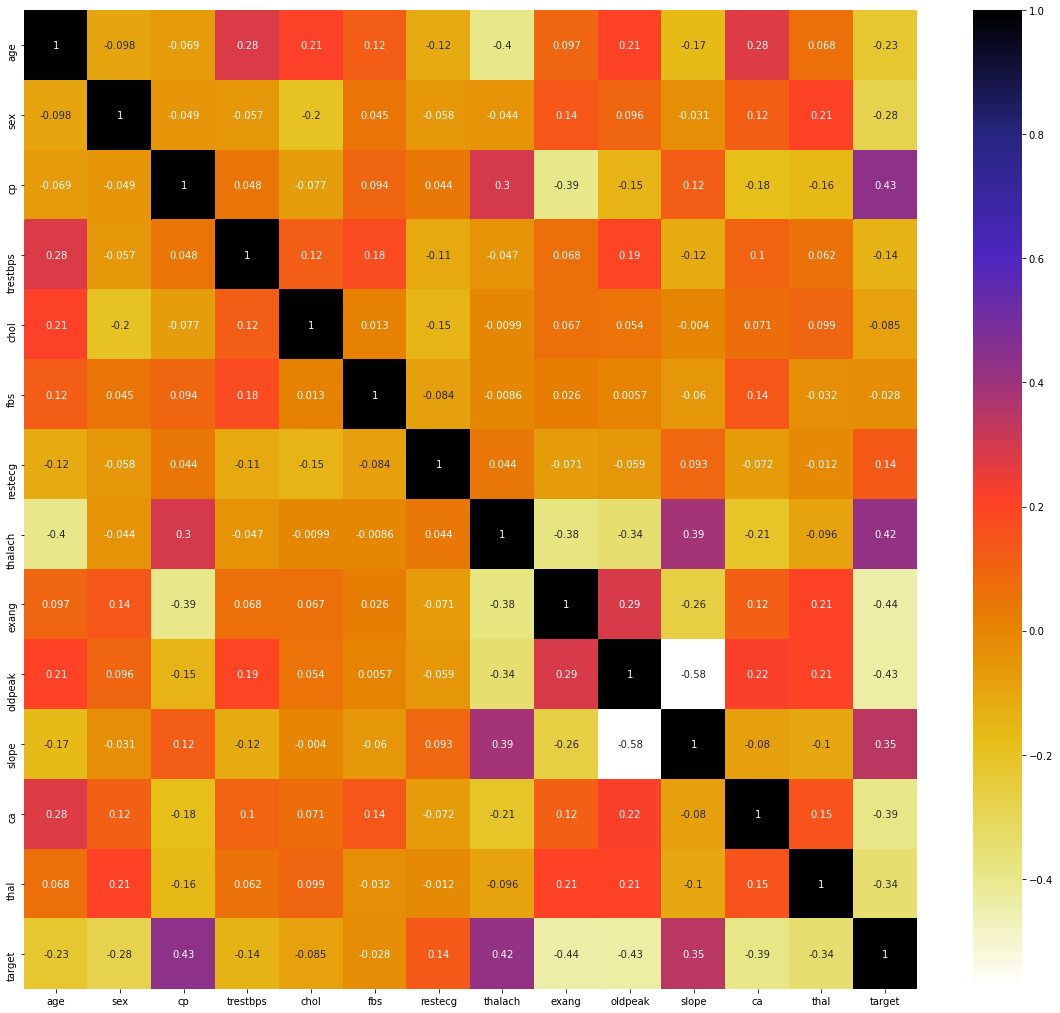

In [ ]:
import seaborn as sns
plt.figure(figsize=(20,18))
cor = dataset3.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)

In [ ]:
dataset3.shape

(303, 14)

In [ ]:
dataset3.head()

age  sex  cp  trestbps      chol  fbs  restecg   thalach  exang  \
0  0.952197    1   3  0.763956 -0.256334    1        0  0.015443      0   
1 -1.915313    1   2 -0.092738  0.072199    0        1  1.633471      0   
2 -1.474158    0   1 -0.092738 -0.816773    0        0  0.977514      0   
3  0.180175    1   1 -0.663867 -0.198357    0        1  1.239897      0   
4  0.290464    0   0 -0.663867  2.082050    0        1  0.583939      1   

    oldpeak  slope  ca  thal  target  
0  1.087338      0   0     1       1  
1  2.122573      0   0     2       1  
2  0.310912      2   0     2       1  
3 -0.206705      2   0     2       1  
4 -0.379244      2   0     2       1

### Splitting the dataset into X_train3 and y_train3

In [ ]:
X_train3 = dataset3.loc[:,dataset3.columns!='target']
y_train3 = dataset3.target

### Train - Test Split

In [ ]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_train3, y_train3, stratify = y_train3,test_size = 0.3)

# Self-Training Classifier
<img src="files/SelfTrain.png" style="height:400px; width:550px;" align="left"/>

In [ ]:
class SelfTrain():
    def __init__(self,base_model) -> None:
        self.model = base_model

    def fit(self,X_lab,y_lab,X_ulab,threshold=0.75):
        
        if X_ulab is None:
            self.model.fit(X_lab,y_lab)
            return
        
        high_prob = [1] # Value to initiate while loop
        pseudo_labels = []
        
        while(len(high_prob) > 0 and len(X_ulab)>0):
            self.model.fit(X_lab,y_lab)
            
            y_pred_prob = self.model.predict_proba(X_ulab)
            y_pred = self.model.predict(X_ulab)
            prob_0 = y_pred_prob[:,0]
            prob_1 = y_pred_prob[:,1]
            
            # Store predictions and probabilities in dataframe
            df_pred_prob = pd.DataFrame([])
            df_pred_prob['preds'] = y_pred
            df_pred_prob['prob_0'] = prob_0
            df_pred_prob['prob_1'] = prob_1
            df_pred_prob.index = X_ulab.index
            
            # Separate predictions with probability above threshold
            high_prob = pd.concat([df_pred_prob.loc[df_pred_prob['prob_0'] > threshold],
                           df_pred_prob.loc[df_pred_prob['prob_1'] > threshold]],
                          axis=0)
            
            pseudo_labels.append(len(high_prob))
            
            # Add pseudo-labeled data to labelled data
            X_lab = pd.concat([X_lab, X_ulab.loc[high_prob.index]], axis=0)
            y_lab = pd.concat([y_lab, high_prob.preds])  
            
            # Drop pseudo-labeled instances from unlabeled data
            X_ulab = X_ulab.drop(index=high_prob.index)

    def predict(self,X):
        return self.model.predict(X)

    def predict_proba(self,X):
        return self.model.predict_proba(X)

### Imbalanced Dataset 1

Best Performing models

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=100,splitter='random',random_state=42)
rf = RandomForestClassifier(criterion='gini',max_depth=70,n_estimators=50,random_state=42)
svm = SVC(gamma='auto',degree=2,kernel='rbf',C=10,random_state=42,probability=True)
knn = KNeighborsClassifier(n_neighbors=3,algorithm='auto',p=1)
mlp = MLPClassifier(max_iter=300,solver='adam',learning_rate='adaptive',activation='relu',verbose='true',batch_size=128,hidden_layer_sizes=(100,100),random_state=42)
gb = GradientBoostingClassifier(learning_rate=0.5,loss='deviance',n_estimators=50,subsample=1,criterion='friedman_mse',max_depth=20,max_features='log2')

### Printing Unlabel Performance for Dataset 1 Unbalanced


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.3027

ACCURACY: 0.90

F1 SCORE: 0.63


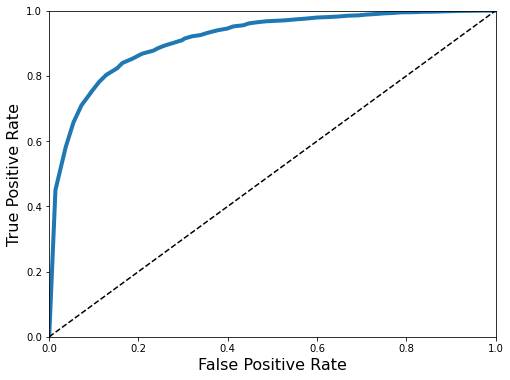


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 3.4505

ACCURACY: 0.90

F1 SCORE: 0.63


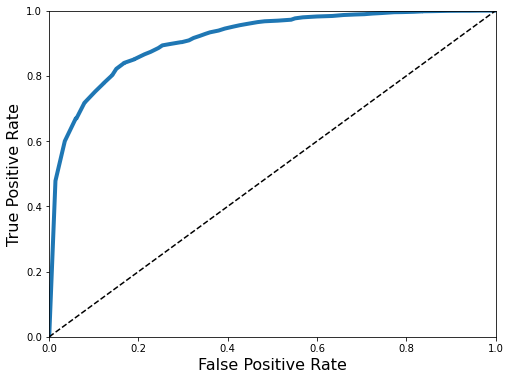


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 4.0532

ACCURACY: 0.89

F1 SCORE: 0.61


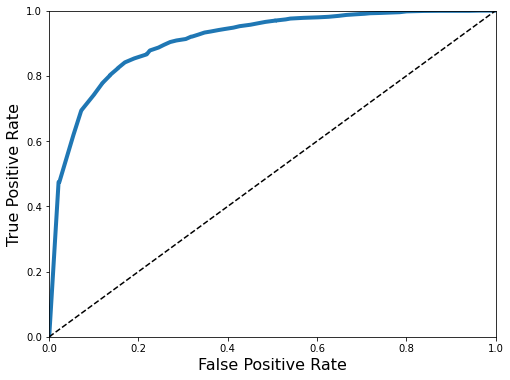


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 7.5026

ACCURACY: 0.89

F1 SCORE: 0.60


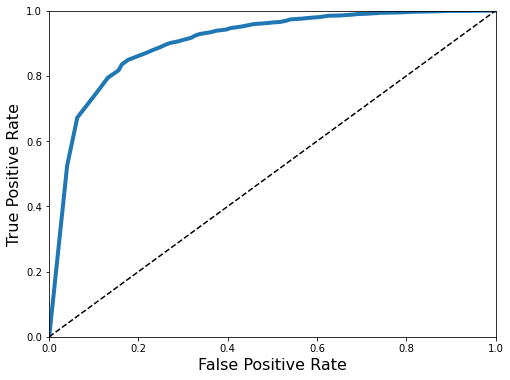


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 6.4630

ACCURACY: 0.89

F1 SCORE: 0.51


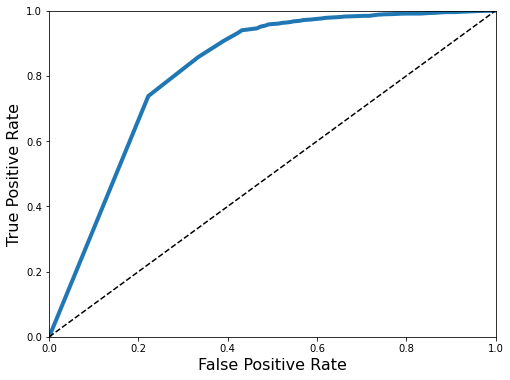


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 5.8380

ACCURACY: 0.88

F1 SCORE: 0.44


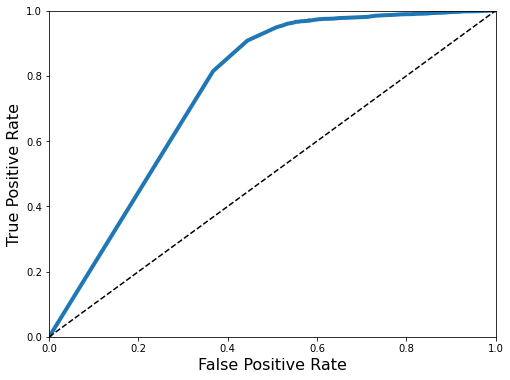

In [ ]:
base_model = rf
unlabel_percent = [0.0,0.1,0.2,0.5,0.9,0.95]
score = []
timer = []

for unlabelled in unlabel_percent:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    X_lab,X_ulab,y_lab = Unlabel(X_train1,y_train1,unlabel_percent=unlabelled)
    start = time.time() # Starting the Timer
    Self = SelfTrain(base_model)
    Self.fit(X_lab,y_lab,X_ulab,threshold=0.9)
    y_pred = Self.predict(X_test1)
    end = time.time() # Ending the Timer
    
    y_pred_prob = Self.predict_proba(X_test1)
    score.append(f1_score(y_test1,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test1,y_pred,start,end,y_pred_prob)

In [ ]:
ST_D1 = pd.DataFrame(score,columns=['ST_D1'],index=["0%","10%","20%","50%","90%","95%"])
time_ST_D1 = pd.DataFrame(timer,columns=['time_ST_D1'],index=["0%","10%","20%","50%","90%","95%"])

In [ ]:
ST_D1

ST_D1
0%   0.625743
10%  0.626104
20%  0.610611
50%  0.596349
90%  0.509849
95%  0.435424

### Over-Sampling Dataset 1

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
sm = SMOTE(random_state=42)
X_train1_over,y_train1_over = sm.fit_resample(X_train1,y_train1)

### Over-Sampled Dataset 1

#### Picking the best model and threshold value

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=100,splitter='random',random_state=42)
rf = RandomForestClassifier(criterion='gini',max_depth=70,n_estimators=50,random_state=42)
svm = SVC(gamma='auto',degree=2,kernel='rbf',C=10,random_state=42,probability=True)
knn = KNeighborsClassifier(n_neighbors=3,algorithm='auto',p=1)
mlp = MLPClassifier(max_iter=300,solver='adam',learning_rate='adaptive',activation='relu',verbose='true',batch_size=128,hidden_layer_sizes=(100,100),random_state=42)
gb = GradientBoostingClassifier(learning_rate=0.5,loss='deviance',n_estimators=50,subsample=1,criterion='friedman_mse',max_depth=20,max_features='log2')

### Printing Unlabel Performance for Dataset 1 Over-Sampled


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.6309

ACCURACY: 0.88

F1 SCORE: 0.64


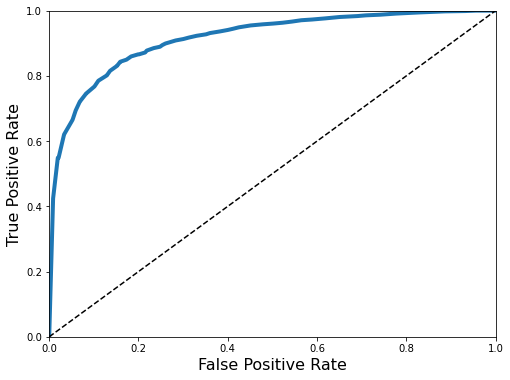


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 5.7828

ACCURACY: 0.89

F1 SCORE: 0.66


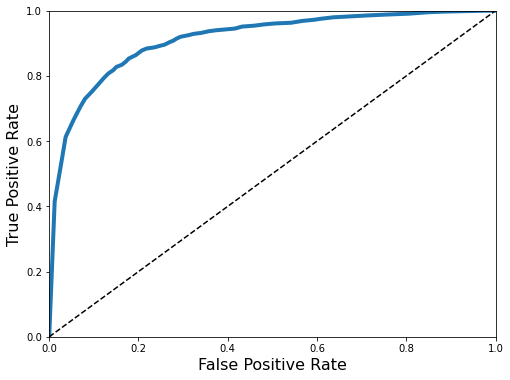


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 8.5662

ACCURACY: 0.88

F1 SCORE: 0.65


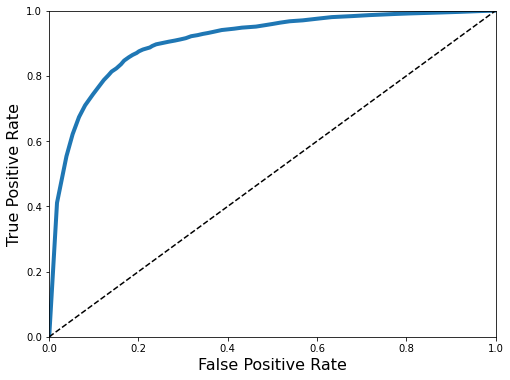


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 14.5547

ACCURACY: 0.87

F1 SCORE: 0.65


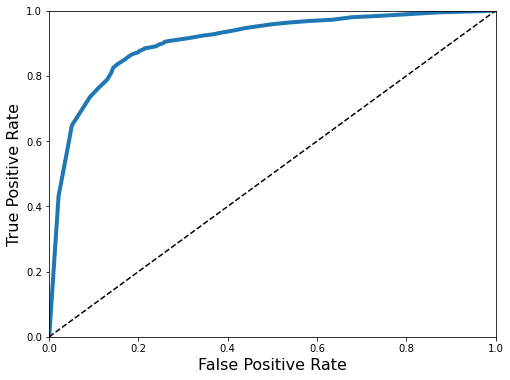


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 6.2068

ACCURACY: 0.86

F1 SCORE: 0.64


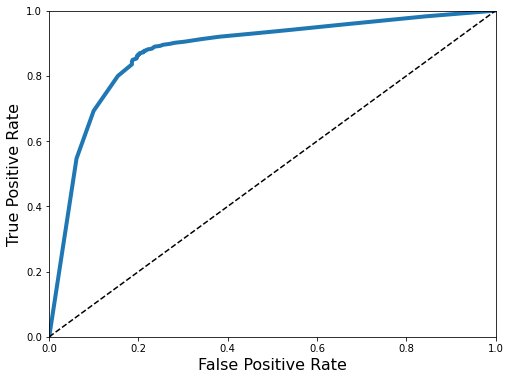


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 6.7242

ACCURACY: 0.85

F1 SCORE: 0.62


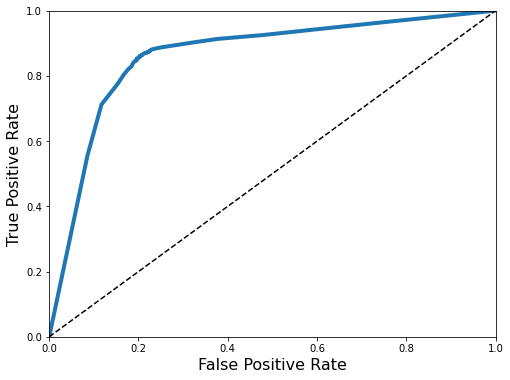

In [ ]:
base_model = rf
unlabel_percent = [0.0,0.1,0.2,0.5,0.9,0.95]
score = []
timer = []

for unlabelled in unlabel_percent:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    X_lab,X_ulab,y_lab = Unlabel(X_train1_over,y_train1_over,unlabel_percent=unlabelled)
    start = time.time() # Starting the Timer
    Self = SelfTrain(base_model)
    Self.fit(X_lab,y_lab,X_ulab,threshold=0.7)
    y_pred = Self.predict(X_test1)
    end = time.time() # Ending the Timer
    
    y_pred_prob = Self.predict_proba(X_test1)
    score.append(f1_score(y_test1,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test1,y_pred,start,end,y_pred_prob)

In [ ]:
ST_D1_Over = pd.DataFrame(score,columns=['ST_D1_Over'],index=["0%","10%","20%","50%","90%","95%"])
time_ST_D1_Over = pd.DataFrame(timer,columns=['time_ST_D1_Over'],index=["0%","10%","20%","50%","90%","95%"])
result1 = ST_D1.merge(ST_D1_Over,left_index=True,right_index=True)
time1 = time_ST_D1.merge(time_ST_D1_Over,left_index=True,right_index=True)

In [ ]:
result1

ST_D1  ST_D1_Over
0%   0.625743    0.642682
10%  0.626104    0.658517
20%  0.610611    0.645367
50%  0.596349    0.647719
90%  0.509849    0.635724
95%  0.435424    0.624055

### Under-Sampling Dataset 1

In [ ]:
from imblearn.under_sampling import RandomUnderSampler 

In [ ]:
under_sampler = RandomUnderSampler(sampling_strategy=0.5,random_state=42)
X_train1_under,y_train1_under = under_sampler.fit_resample(X_train1,y_train1)

#### Picking the best model and threshold value

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=100,splitter='random',random_state=42)
rf = RandomForestClassifier(criterion='gini',max_depth=70,n_estimators=50,random_state=42)
svm = SVC(gamma='auto',degree=2,kernel='rbf',C=10,random_state=42,probability=True)
knn = KNeighborsClassifier(n_neighbors=3,algorithm='auto',p=1)
mlp = MLPClassifier(max_iter=300,solver='adam',learning_rate='adaptive',activation='relu',verbose='true',batch_size=128,hidden_layer_sizes=(100,100),random_state=42)
gb = GradientBoostingClassifier(learning_rate=0.5,loss='deviance',n_estimators=50,subsample=1,criterion='friedman_mse',max_depth=20,max_features='log2')

### Printing Unlabel Performance for Dataset 1 Under-Sampled


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.1928

ACCURACY: 0.87

F1 SCORE: 0.63


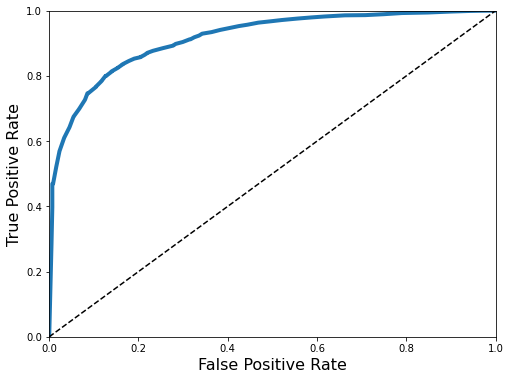


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 1.3457

ACCURACY: 0.88

F1 SCORE: 0.65


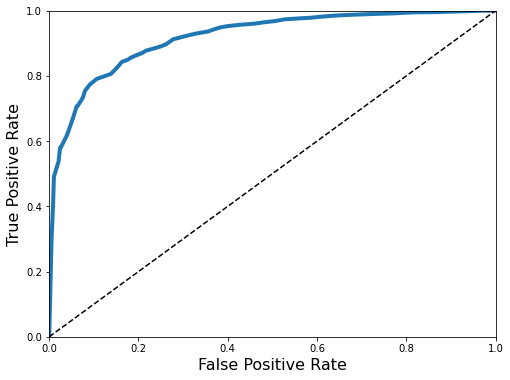


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 2.0369

ACCURACY: 0.88

F1 SCORE: 0.63


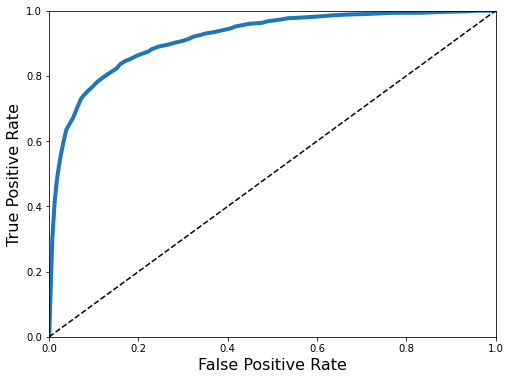


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 3.4631

ACCURACY: 0.88

F1 SCORE: 0.66


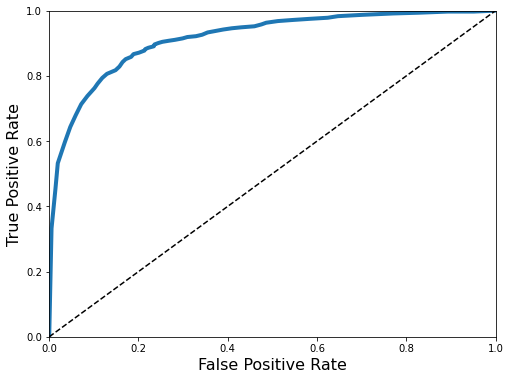


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 1.9656

ACCURACY: 0.88

F1 SCORE: 0.62


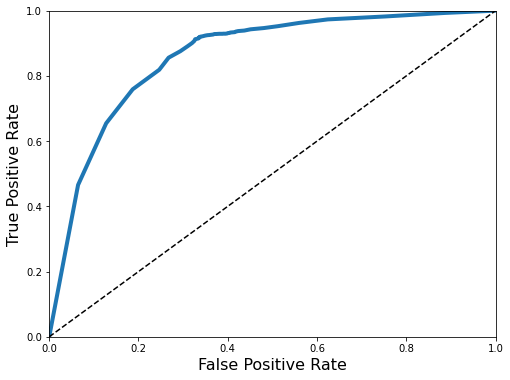


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 1.3665

ACCURACY: 0.88

F1 SCORE: 0.63


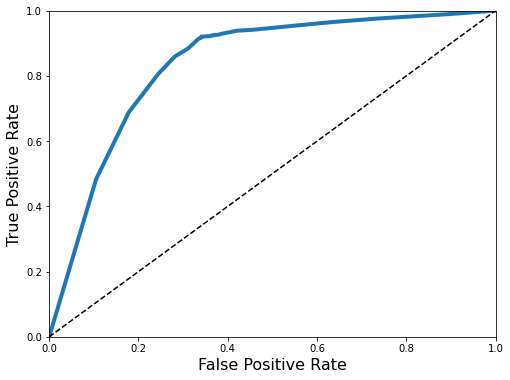

In [ ]:
base_model = rf
unlabel_percent = [0.0,0.1,0.2,0.5,0.9,0.95]
score = []
timer = []

for unlabelled in unlabel_percent:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    X_lab,X_ulab,y_lab = Unlabel(X_train1_under,y_train1_under,unlabel_percent=unlabelled)
    start = time.time() # Starting the Timer
    Self = SelfTrain(base_model)
    Self.fit(X_lab,y_lab,X_ulab,threshold=0.8)
    y_pred = Self.predict(X_test1)
    end = time.time() # Ending the Timer
    
    y_pred_prob = Self.predict_proba(X_test1)
    score.append(f1_score(y_test1,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test1,y_pred,start,end,y_pred_prob)

In [ ]:
ST_D1_Under = pd.DataFrame(score,columns=['ST_D1_Under'],index=["0%","10%","20%","50%","90%","95%"])
time_ST_D1_Under = pd.DataFrame(timer,columns=['time_ST_D1_Under'],index=["0%","10%","20%","50%","90%","95%"])
result1 = result1.merge(ST_D1_Under,left_index=True,right_index=True)
time1 = time1.merge(time_ST_D1_Under,left_index=True,right_index=True)

In [ ]:
result1

ST_D1  ST_D1_Over  ST_D1_Under
0%   0.625743    0.642682     0.630284
10%  0.626104    0.658517     0.649533
20%  0.610611    0.645367     0.634921
50%  0.596349    0.647719     0.657935
90%  0.509849    0.635724     0.620451
95%  0.435424    0.624055     0.625839

### Dataset 2 [Self Training]

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=10,splitter='best',random_state=42)
rf = RandomForestClassifier(criterion='entropy',max_depth=100,n_estimators=60,random_state=42)
svm = SVC(gamma='auto',degree=6,kernel='rbf',C=20,random_state=42,probability=True)
knn = KNeighborsClassifier(n_neighbors=7,algorithm='auto',p=1)
mlp = MLPClassifier(max_iter=300,solver='adam',learning_rate='adaptive',activation='logistic',verbose='true',batch_size=64,hidden_layer_sizes=(30,30,30),random_state=42)
gb = GradientBoostingClassifier(learning_rate=0.5,loss='exponential',n_estimators=80,subsample=1,criterion='mse',max_depth=5,max_features='sqrt')

### Printing Unlabel Performance for Dataset 2


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.1493

ACCURACY: 0.89

F1 SCORE: 0.89


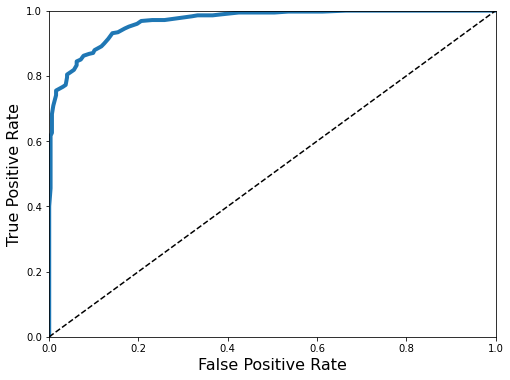


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.7207

ACCURACY: 0.91

F1 SCORE: 0.91


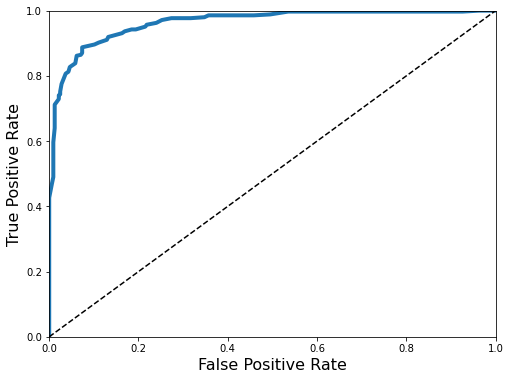


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.9295

ACCURACY: 0.88

F1 SCORE: 0.88


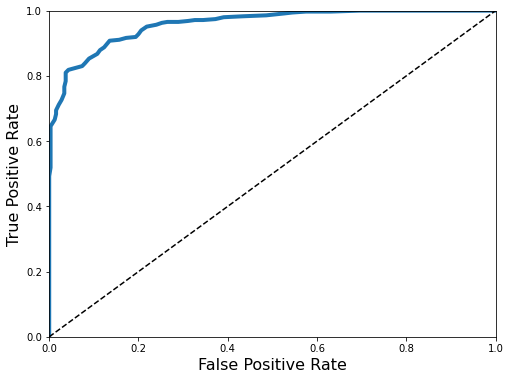


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 1.6203

ACCURACY: 0.87

F1 SCORE: 0.86


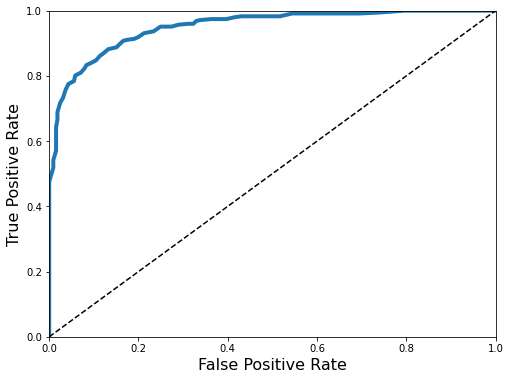


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 1.3522

ACCURACY: 0.83

F1 SCORE: 0.82


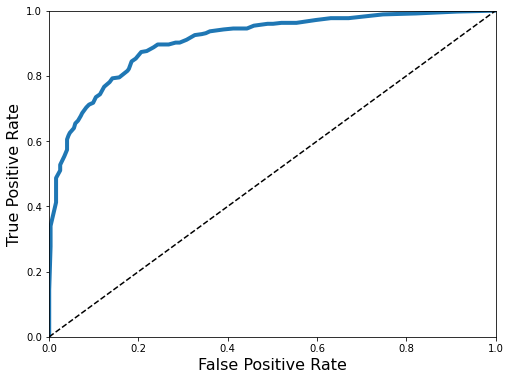


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 1.2349

ACCURACY: 0.81

F1 SCORE: 0.80


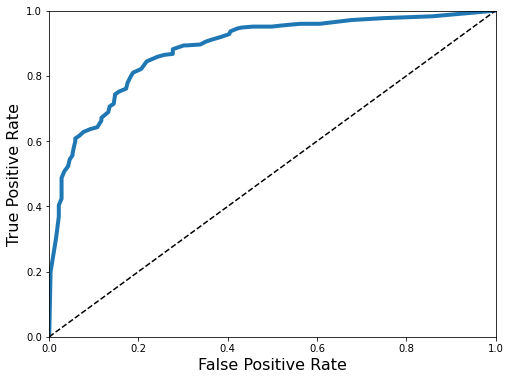

In [ ]:
base_model = rf
unlabel_percent = [0.0,0.1,0.2,0.5,0.9,0.95]
score = []
timer = []

for unlabelled in unlabel_percent:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    X_lab,X_ulab,y_lab = Unlabel(X_train2,y_train2,unlabel_percent=unlabelled)
    start = time.time() # Starting the Timer
    Self = SelfTrain(base_model)
    Self.fit(X_lab,y_lab,X_ulab,threshold=0.9)
    y_pred = Self.predict(X_test2)
    end = time.time() # Ending the Timer
    
    y_pred_prob = Self.predict_proba(X_test2)
    score.append(f1_score(y_test2,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test2,y_pred,start,end,y_pred_prob)

In [ ]:
ST_D2 = pd.DataFrame(score,columns=['ST_D2'],index=["0%","10%","20%","50%","90%","95%"])
time_ST_D2 = pd.DataFrame(timer,columns=['time_ST_D2'],index=["0%","10%","20%","50%","90%","95%"])
result1 = result1.merge(ST_D2,left_index=True,right_index=True)
time1 = time1.merge(time_ST_D2,left_index=True,right_index=True)

In [ ]:
result1

ST_D1  ST_D1_Over  ST_D1_Under     ST_D2
0%   0.625743    0.642682     0.630284  0.886191
10%  0.626104    0.658517     0.649533  0.905263
20%  0.610611    0.645367     0.634921  0.879389
50%  0.596349    0.647719     0.657935  0.862500
90%  0.509849    0.635724     0.620451  0.822981
95%  0.435424    0.624055     0.625839  0.803625

### Dataset 3 [Self Training]

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=3,splitter='best',random_state=42)
rf = RandomForestClassifier(criterion='gini',max_depth=4,n_estimators=60,random_state=42)
svm = SVC(gamma='scale',degree=8,kernel='rbf',C=1,random_state=42,probability=True)
knn = KNeighborsClassifier(n_neighbors=5,algorithm='auto',p=1)
mlp = MLPClassifier(max_iter=300,solver='adam',learning_rate='adaptive',activation='logistic',verbose='true',batch_size=32,hidden_layer_sizes=(20,20,20),random_state=42)
gb = GradientBoostingClassifier(learning_rate=0.1,loss='exponential',n_estimators=80,subsample=0.5,criterion='mse',max_depth=20,max_features='sqrt')

### Printing Unlabel Performance for Dataset 3


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.0205

ACCURACY: 0.81

F1 SCORE: 0.83


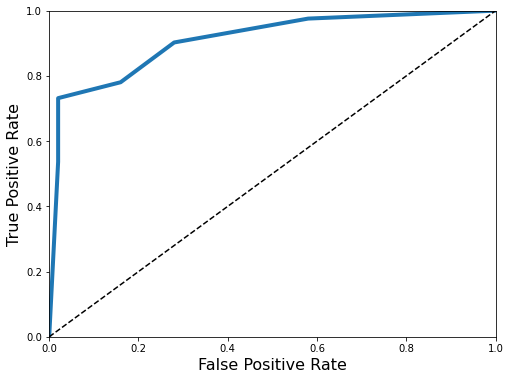


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.0193

ACCURACY: 0.81

F1 SCORE: 0.83


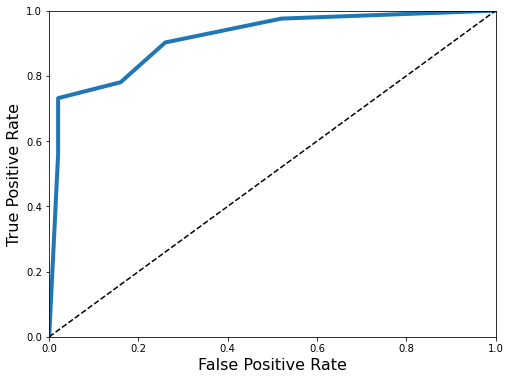


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.0339

ACCURACY: 0.82

F1 SCORE: 0.84


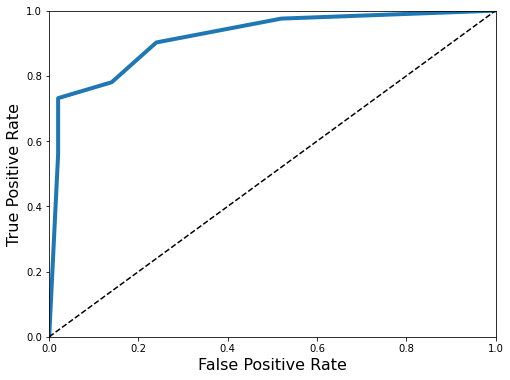


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.0427

ACCURACY: 0.86

F1 SCORE: 0.88


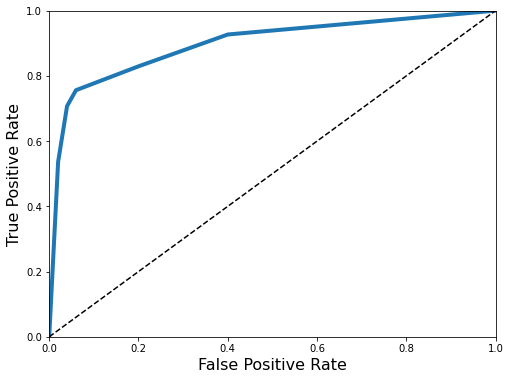


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.0730

ACCURACY: 0.84

F1 SCORE: 0.86


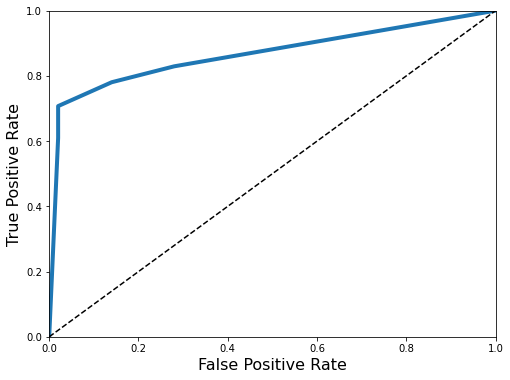


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.0127

ACCURACY: 0.78

F1 SCORE: 0.81


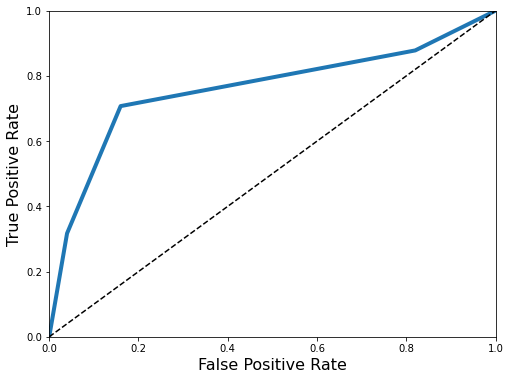

In [ ]:
base_model = knn
unlabel_percent = [0.0,0.1,0.2,0.5,0.9,0.95]
score = []
timer = []

for unlabelled in unlabel_percent:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    X_lab,X_ulab,y_lab = Unlabel(X_train3,y_train3,unlabel_percent=unlabelled)
    start = time.time() # Start the Timer
    Self = SelfTrain(base_model)
    Self.fit(X_lab,y_lab,X_ulab,threshold=0.9)
    y_pred = Self.predict(X_test3)
    end = time.time() # End the Timer
    
    y_pred_prob = Self.predict_proba(X_test3)
    score.append(f1_score(y_test3,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test3,y_pred,start,end,y_pred_prob)

In [ ]:
ST_D3 = pd.DataFrame(score,columns=['ST_D3'],index=["0%","10%","20%","50%","90%","95%"])
time_ST_D3 = pd.DataFrame(timer,columns=['time_ST_D3'],index=["0%","10%","20%","50%","90%","95%"])
result1 = result1.merge(ST_D3,left_index=True,right_index=True)
time1 = time1.merge(time_ST_D3,left_index=True,right_index=True)

In [ ]:
result1

ST_D1  ST_D1_Over  ST_D1_Under     ST_D2     ST_D3
0%   0.625743    0.642682     0.630284  0.886191  0.831683
10%  0.626104    0.658517     0.649533  0.905263  0.831683
20%  0.610611    0.645367     0.634921  0.879389  0.843137
50%  0.596349    0.647719     0.657935  0.862500  0.878505
90%  0.509849    0.635724     0.620451  0.822981  0.857143
95%  0.435424    0.624055     0.625839  0.803625  0.807692

In [ ]:
result1.to_csv('data/result_ST.csv')

In [ ]:
time1.to_csv('data/time_ST.csv')

### Summary

In [ ]:
result1 = pd.read_csv('result_ST.csv')
result1.set_index("Unnamed: 0",inplace=True)
dataset1 = list(result1.iloc[:,0])
dataset1_over = list(result1.iloc[:,1])
dataset1_under = list(result1.iloc[:,2])
dataset2 = list(result1.iloc[:,3])
dataset3 = list(result1.iloc[:,4])

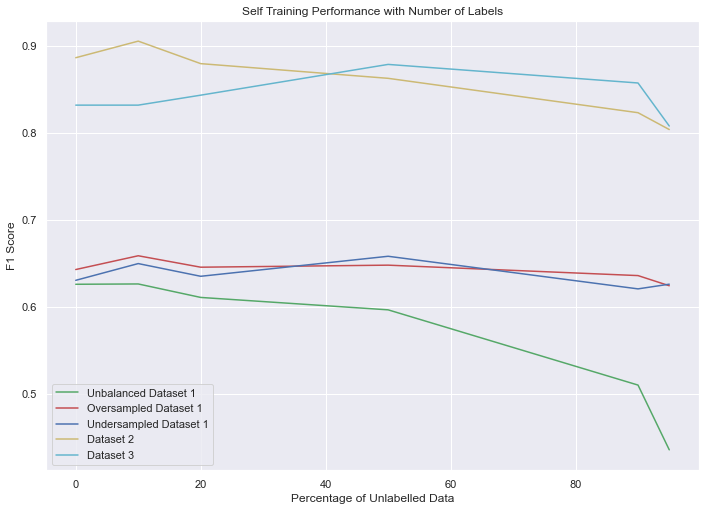

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
epochs = [0,10,20,50,90,95]
plt.plot(epochs, dataset1, 'g', label='Unbalanced Dataset 1')
plt.plot(epochs, dataset1_over, 'r', label='Oversampled Dataset 1')
plt.plot(epochs, dataset1_under, 'b', label='Undersampled Dataset 1')
plt.plot(epochs, dataset2, 'y', label='Dataset 2')
plt.plot(epochs, dataset3, 'c', label='Dataset 3')
plt.title('Self Training Performance with Number of Labels')
plt.xlabel('Percentage of Unlabelled Data')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Converting the Data to Numpy

In [ ]:
X_train1 = X_train1.values
y_train1 = y_train1.values
X_test1 = X_test1.values
y_test1 = y_test1.values

In [ ]:
X_train1_over = X_train1_over.values
y_train1_over = y_train1_over.values

In [ ]:
X_train1_under = X_train1_under.values
y_train1_under = y_train1_under.values

In [ ]:
X_train2 = X_train2.values
y_train2 = y_train2.values
X_test2 = X_test2.values
y_test2 = y_test2.values

In [ ]:
X_train3 = X_train3.values
y_train3 = y_train3.values
X_test3 = X_test3.values
y_test3 = y_test3.values

# Semi-Boost Classifier
<img src="files/SemiBoost.png" style="height:400px; width:550px;" align="left"/>
[Reference->https://github.com/papabloblo/semi_boost/tree/master/src]

In [ ]:
class SemiBoostClassifier():

    def __init__(self, base_model =SVC()):

        self.BaseModel = base_model
        self.weights = None

    def fit(self, X, y,
            n_neighbors=4, n_jobs = 1,
            max_models = 15,
            sample_percent = 0.5,
            sigma_percentile = 90,
            similarity_kernel = 'rbf',
            verbose = False):
        
        #Localize labeled data
        label_index = np.argwhere((y == 0) | (y == 1)).flatten()
        unlabel_index = np.array([i for i in np.arange(len(y)) if i not in label_index])

        # For Fully Supervised Learning
        if unlabel_index.size == 0:
            index = np.where(y!=-1)
            X,y = X[index],y[index]
            self.BaseModel.fit(X,y)
            return 

        # First we need to create the similarity matrix
        if similarity_kernel == 'knn':

            graph = neighbors.kneighbors_graph(X,
                                                n_neighbors=n_neighbors,
                                                mode='distance',
                                                include_self=True,
                                                n_jobs=n_jobs)

            graph = sparse.csr_matrix(graph)

        elif similarity_kernel == 'rbf':
            # First aprox
            graph = np.sqrt(rbf_kernel(X, gamma = 1))
            # set gamma parameter as the 15th percentile
            sigma = np.percentile(np.log(graph), sigma_percentile)
            sigma_2 = (1/sigma**2)*np.ones((graph.shape[0],graph.shape[0]))
            graph = np.power(graph, sigma_2)
            # Matrix to sparse
            graph = sparse.csr_matrix(graph)

        else:
            print('No kernel type ', similarity_kernel)

        # Initialise variables
        self.models = []
        self.weights = []
        H = np.zeros(unlabel_index.shape[0])

        # Loop for adding sequential models
        for t in range(max_models):
            # Calculate p_i and q_i for every sample
            p_1 = np.einsum('ij,j', graph[:,label_index].todense(), (y[label_index]==1))[unlabel_index]*np.exp(-2*H)
            p_2 = np.einsum('ij,j', graph[:,unlabel_index].todense(), np.exp(H))[unlabel_index]*np.exp(-H)
            p = np.add(p_1, p_2)
            p = np.squeeze(np.asarray(p))

            q_1 = np.einsum('ij,j', graph[:,label_index].todense(), (y[label_index]==-1))[unlabel_index]*np.exp(2*H)
            q_2 = np.einsum('ij,j', graph[:,unlabel_index].todense(), np.exp(-H))[unlabel_index]*np.exp(H)
            q = np.add(q_1, q_2)
            q = np.squeeze(np.asarray(q))

            # Compute predicted label z_i
            z = np.sign(p-q)
            z_conf = np.abs(p-q)
            # Sample sample_percent most confident predictions
            # Sampling weights
            sample_weights = z_conf/np.sum(z_conf)
            # If there are non-zero weights
            if np.any(sample_weights != 0):
                try:
                    pick = np.random.choice(np.arange(z.size),
                                              size = int(sample_percent*unlabel_index.size),
                                              p = sample_weights,
                                              replace = False)
                except:
                    continue
                sample_index = unlabel_index[pick]

            else:
                print('No similar unlabeled observations left.')
                break

            # Create new X_t, y_t
            total_sample = np.concatenate([label_index,sample_index])
            X_t = X[total_sample,]
            np.put(y, sample_index, z[pick])# Include predicted to train new model
            y_t = y[total_sample]

            # Fit BaseModel to samples using predicted labels
            # Fit model to unlabeled observations
            clf = self.BaseModel
            try:
                clf.fit(X_t, y_t)
            except:
                continue
            # Make predictions for unlabeled observations
            h = clf.predict(X[unlabel_index])

            # Refresh indexes
            label_index = total_sample
            unlabel_index = np.array([i for i in np.arange(len(y)) if i not in label_index])

            if verbose:
                print('There are still ', unlabel_index.shape[0], ' unlabeled observations')

            # Compute weight (a) for the BaseModel as in (12)
            e = (np.dot(p,h==-1) + np.dot(q,h==1))/(np.sum(np.add(p,q)))
            a = 0.25*np.log((1-e)/e)
            # Update final model
            # If a<0 the model is not converging
            if a<0:
                if verbose:
                    print('Problematic convergence of the model. a<0')
                break

            # Save model
            self.models.append(clf)
            #save weights
            self.weights.append(a)
            # Update
            H = np.zeros(len(unlabel_index))
            w = np.sum(self.weights)
            for i in range(len(self.models)):
                H = np.add(H, self.weights[i]*self.models[i].predict(X[unlabel_index]))

            # Breaking conditions

            # Maximum number of models reached
            if (t==max_models) & verbose:
                print('Maximum number of models reached')

            # If no samples are left without label, break
            if unlabel_index.size <= 1:
                if verbose:
                    print('All observations have been labeled')
                    print('Number of iterations: ',t + 1)
                break

        if verbose:
            print('\n The model weights are \n')
            print(self.weights)



    def predict(self, X):
        if self.weights is None:
            return self.BaseModel.predict(X)
        
        estimate = np.zeros(X.shape[0])
        # Predict weighting each model
        w = np.sum(self.weights)
        for i in range(len(self.models)):
            estimate = np.add(estimate, self.weights[i]*self.models[i].predict(X))
        estimate = np.array(list(map(lambda x: 1 if x>0 else 0, estimate)))
        estimate = estimate.astype(int)
        return estimate


### Imbalanced Dataset 1 [SemiBoost]

#### Using the best base models

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=100,splitter='random',random_state=42)
rf = RandomForestClassifier(criterion='gini',max_depth=70,n_estimators=50,random_state=42)
svm = SVC(gamma='auto',degree=2,kernel='rbf',C=10,random_state=42,probability=True)
knn = KNeighborsClassifier(n_neighbors=3,algorithm='auto',p=1)
mlp = MLPClassifier(max_iter=300,solver='adam',learning_rate='adaptive',activation='relu',verbose='true',batch_size=128,hidden_layer_sizes=(100,100),random_state=42)
gb = GradientBoostingClassifier(learning_rate=0.5,loss='deviance',n_estimators=50,subsample=1,criterion='friedman_mse',max_depth=20,max_features='log2')


### Printing Unlabel Performance for Dataset 1 Unbalanced [Semi-Boost]


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.3637

ACCURACY: 0.90

F1 SCORE: 0.63


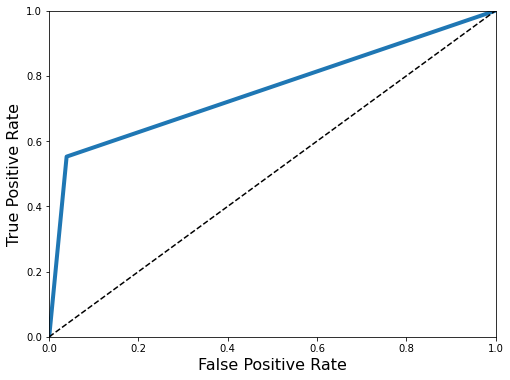


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 27.9096

ACCURACY: 0.88

F1 SCORE: 0.61


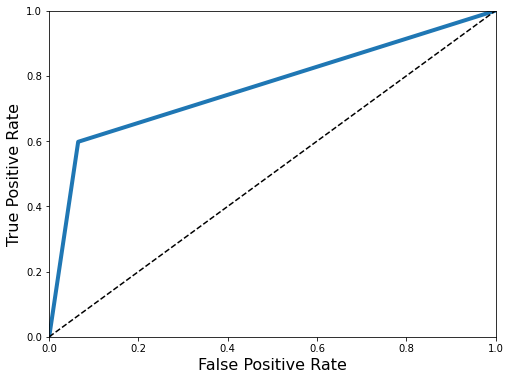


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 32.4259

ACCURACY: 0.86

F1 SCORE: 0.59


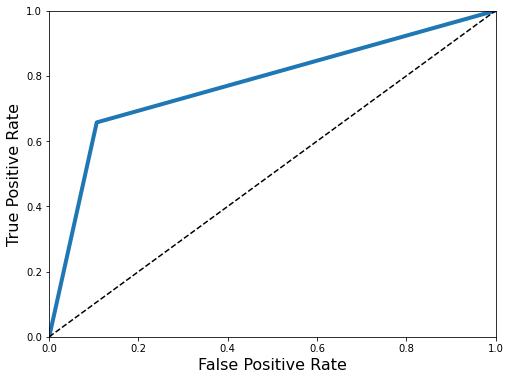


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 36.0993

ACCURACY: 0.49

F1 SCORE: 0.35


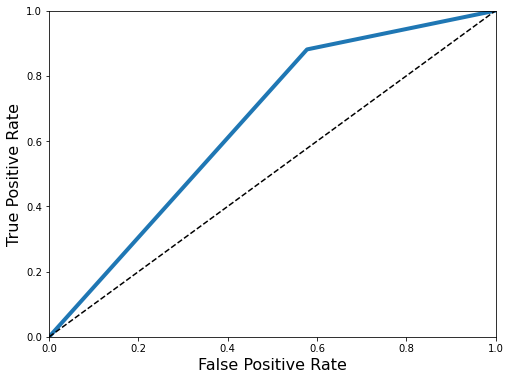


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 41.0882

ACCURACY: 0.17

F1 SCORE: 0.27


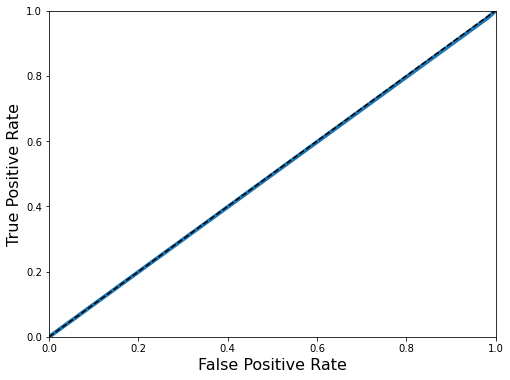


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 40.4609

ACCURACY: 0.16

F1 SCORE: 0.27


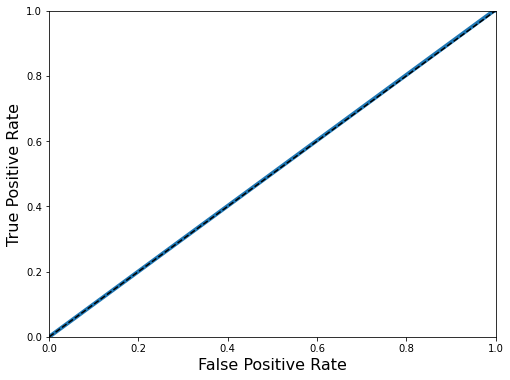

In [ ]:
base_model = rf
unlabel_percent = [0.0,0.1,0.2,0.5,0.9,0.95]
score = []
timer = []

for unlabelled in unlabel_percent:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    X_lab,y_lab = Unlabel(X_train1,y_train1,unlabel_percent=unlabelled,split=False)
    start = time.time() # Start the Timer
    Semi = SemiBoostClassifier(base_model)
    Semi.fit(X_lab,y_lab)
    y_pred = Semi.predict(X_test1)
    end = time.time() # End the Timer
    
    score.append(f1_score(y_test1,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test1,y_pred,start,end)

In [ ]:
Semi_D1 = pd.DataFrame(score,columns=['Semi_D1'],index=["0%","10%","20%","50%","90%","95%"])
time_Semi_D1 = pd.DataFrame(timer,columns=['time_Semi_D1'],index=["0%","10%","20%","50%","90%","95%"])

In [ ]:
Semi_D1

Semi_D1
0%   0.625743
10%  0.612355
20%  0.587041
50%  0.349757
90%  0.266223
95%  0.268545

### Over-Sampled Dataset 1 [SemiBoost]

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=100,splitter='random',random_state=42)
rf = RandomForestClassifier(criterion='gini',max_depth=70,n_estimators=50,random_state=42)
svm = SVC(gamma='auto',degree=2,kernel='rbf',C=10,random_state=42,probability=True)
knn = KNeighborsClassifier(n_neighbors=3,algorithm='auto',p=1)
mlp = MLPClassifier(max_iter=300,solver='adam',learning_rate='adaptive',activation='relu',verbose='true',batch_size=128,hidden_layer_sizes=(100,100),random_state=42)
gb = GradientBoostingClassifier(learning_rate=0.5,loss='deviance',n_estimators=50,subsample=1,criterion='friedman_mse',max_depth=20,max_features='log2')


### Printing Unlabel Performance for Dataset 1 Over-Sampled [Semi-Boost]


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.7392

ACCURACY: 0.88

F1 SCORE: 0.64


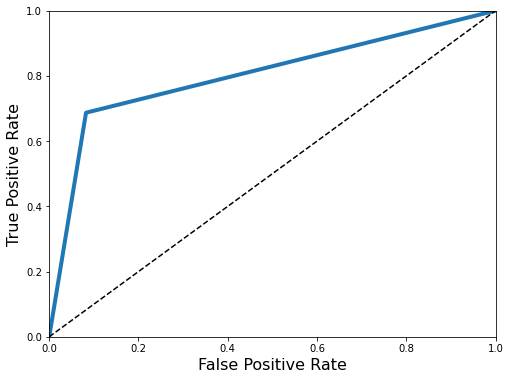


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 324.0245

ACCURACY: 0.85

F1 SCORE: 0.60


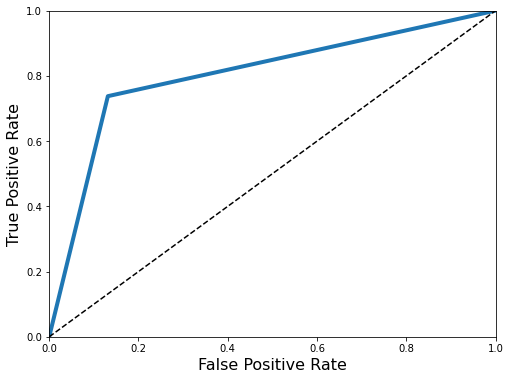


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 253.8101

ACCURACY: 0.72

F1 SCORE: 0.48


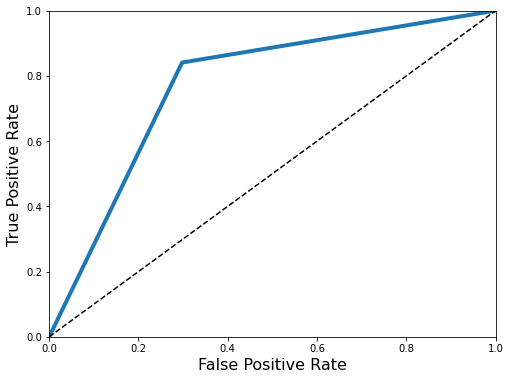


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 265.9521

ACCURACY: 0.17

F1 SCORE: 0.27


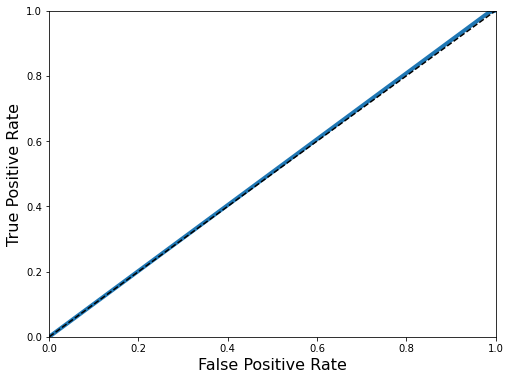


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 277.9359

ACCURACY: 0.15

F1 SCORE: 0.27


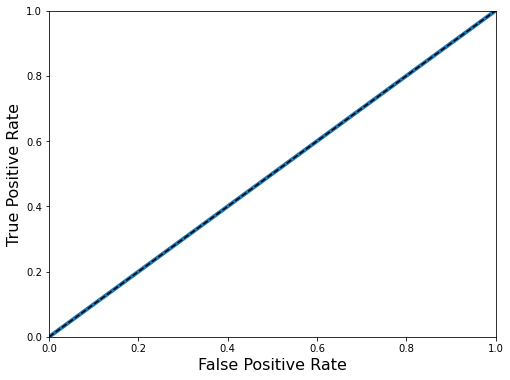


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 398.4438

ACCURACY: 0.15

F1 SCORE: 0.27


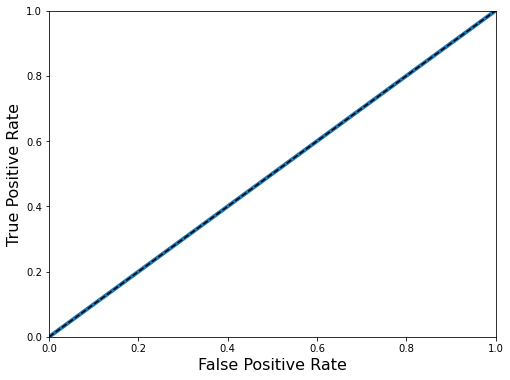

In [ ]:
base_model = rf
unlabel_percent = [0.0,0.1,0.2,0.5,0.9,0.95]
score = []
timer = []

for unlabelled in unlabel_percent:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    X_lab,y_lab = Unlabel(X_train1_over,y_train1_over,unlabel_percent=unlabelled,split=False)
    start = time.time() #Start the Timer
    Semi = SemiBoostClassifier(base_model)
    Semi.fit(X_lab,y_lab,n_neighbors=6)
    y_pred = Semi.predict(X_test1)
    end = time.time() # End the Timer
    
    score.append(f1_score(y_test1,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test1,y_pred,start,end)

In [ ]:
Semi_D1_Over = pd.DataFrame(score,columns=['Semi_D1_Over'],index=["0%","10%","20%","50%","90%","95%"])
time_Semi_D1_Over = pd.DataFrame(timer,columns=['time_Semi_D1_Over'],index=["0%","10%","20%","50%","90%","95%"])
result2 = Semi_D1.merge(Semi_D1_Over,left_index=True,right_index=True)
time2 = time_Semi_D1.merge(time_Semi_D1_Over,left_index=True,right_index=True)

In [ ]:
result2

Semi_D1  Semi_D1_Over
0%   0.625743      0.642682
10%  0.612355      0.600712
20%  0.587041      0.484879
50%  0.349757      0.269604
90%  0.266223      0.267853
95%  0.268545      0.267853

### Under-Sampled Dataset 1 [SemiBoost]

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=100,splitter='random',random_state=42)
rf = RandomForestClassifier(criterion='gini',max_depth=70,n_estimators=50,random_state=42)
svm = SVC(gamma='auto',degree=2,kernel='rbf',C=10,random_state=42,probability=True)
knn = KNeighborsClassifier(n_neighbors=3,algorithm='auto',p=1)
mlp = MLPClassifier(max_iter=300,solver='adam',learning_rate='adaptive',activation='relu',verbose='true',batch_size=128,hidden_layer_sizes=(100,100),random_state=42)
gb = GradientBoostingClassifier(learning_rate=0.5,loss='deviance',n_estimators=50,subsample=1,criterion='friedman_mse',max_depth=20,max_features='log2')

### Printing Unlabel Performance for Dataset 1 Under-Sampled [Semi-Boost]


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.2088

ACCURACY: 0.87

F1 SCORE: 0.63


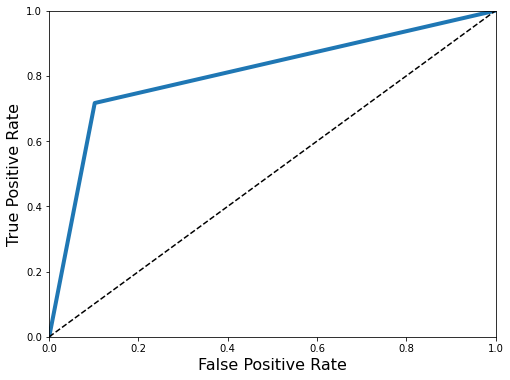


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 5.3052

ACCURACY: 0.84

F1 SCORE: 0.60


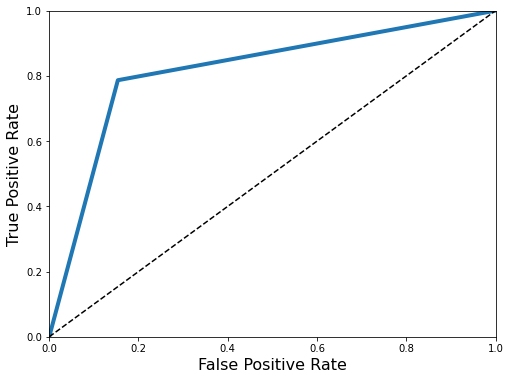


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 5.2989

ACCURACY: 0.73

F1 SCORE: 0.50


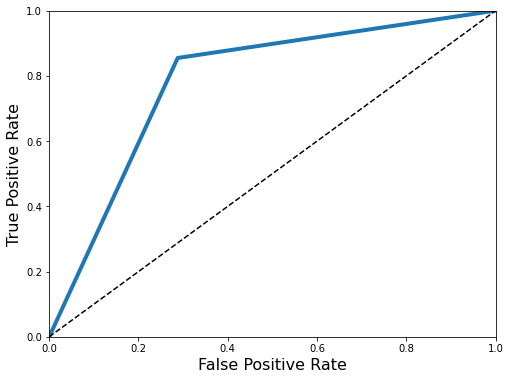


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 5.7776

ACCURACY: 0.19

F1 SCORE: 0.27


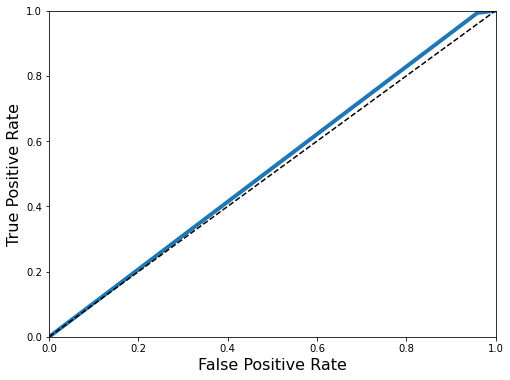


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 4.2076

ACCURACY: 0.15

F1 SCORE: 0.27


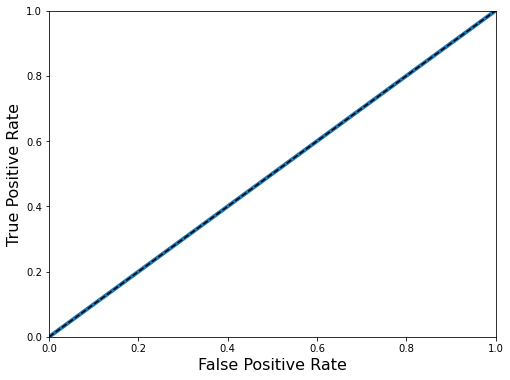


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 4.1891

ACCURACY: 0.15

F1 SCORE: 0.27


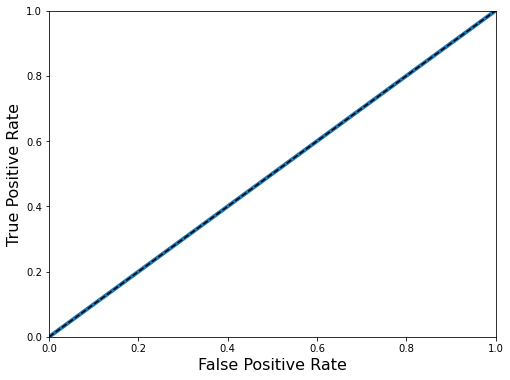

In [ ]:
base_model = rf
unlabel_percent = [0.0,0.1,0.2,0.5,0.9,0.95]
score = []
timer = []

for unlabelled in unlabel_percent:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    X_lab,y_lab = Unlabel(X_train1_under,y_train1_under,unlabel_percent=unlabelled,split=False)
    start = time.time() # Start the Timer
    Semi = SemiBoostClassifier(base_model)
    Semi.fit(X_lab,y_lab,similarity_kernel='rbf')
    y_pred = Semi.predict(X_test1)
    end = time.time() # End the Timer
    
    score.append(f1_score(y_test1,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test1,y_pred,start,end)

In [ ]:
Semi_D1_Under = pd.DataFrame(score,columns=['Semi_D1_Under'],index=["0%","10%","20%","50%","90%","95%"])
time_Semi_D1_Under = pd.DataFrame(timer,columns=['time_Semi_D1_Under'],index=["0%","10%","20%","50%","90%","95%"])
result2 = result2.merge(Semi_D1_Under,left_index=True,right_index=True)
time2 = time2.merge(time_Semi_D1_Under,left_index=True,right_index=True)

In [ ]:
result2

Semi_D1  Semi_D1_Over  Semi_D1_Under
0%   0.625743      0.642682       0.630284
10%  0.612355      0.600712       0.598802
20%  0.587041      0.484879       0.498725
50%  0.349757      0.269604       0.274462
90%  0.266223      0.267853       0.267853
95%  0.268545      0.267853       0.267853

### Dataset 2

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=10,splitter='best',random_state=42)
rf = RandomForestClassifier(criterion='entropy',max_depth=100,n_estimators=60,random_state=42)
svm = SVC(gamma='auto',degree=6,kernel='rbf',C=20,random_state=42,probability=True)
knn = KNeighborsClassifier(n_neighbors=7,algorithm='auto',p=1)
mlp = MLPClassifier(max_iter=300,solver='adam',learning_rate='adaptive',activation='logistic',verbose='true',batch_size=64,hidden_layer_sizes=(30,30,30),random_state=42)
gb = GradientBoostingClassifier(learning_rate=0.5,loss='exponential',n_estimators=80,subsample=1,criterion='mse',max_depth=5,max_features='sqrt')


### Printing Unlabel Performance for Dataset 2 [Semi-Boost]


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.1310

ACCURACY: 0.89

F1 SCORE: 0.89


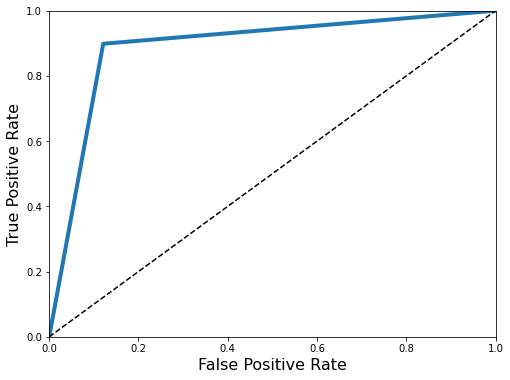


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 1.5758

ACCURACY: 0.88

F1 SCORE: 0.88


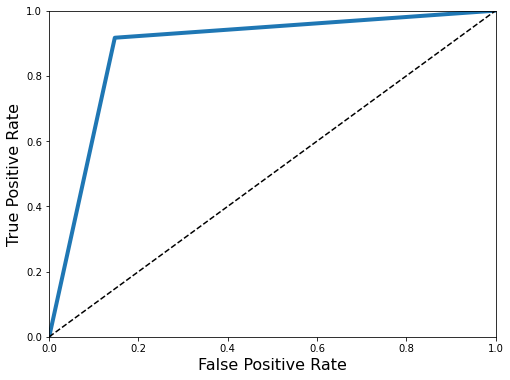


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 1.7740

ACCURACY: 0.86

F1 SCORE: 0.87


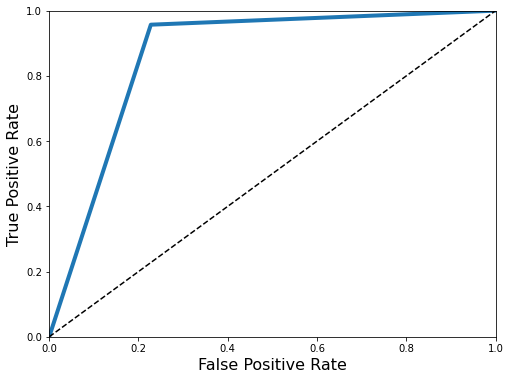


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 1.9403

ACCURACY: 0.65

F1 SCORE: 0.73


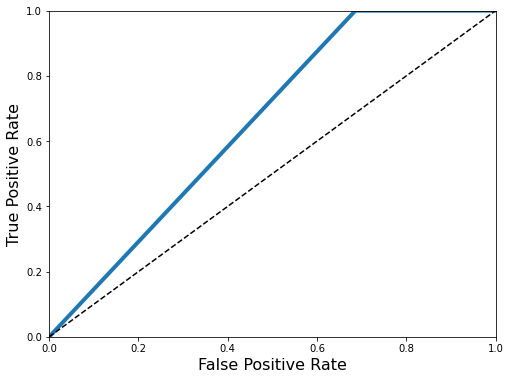


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 1.8572

ACCURACY: 0.49

F1 SCORE: 0.65


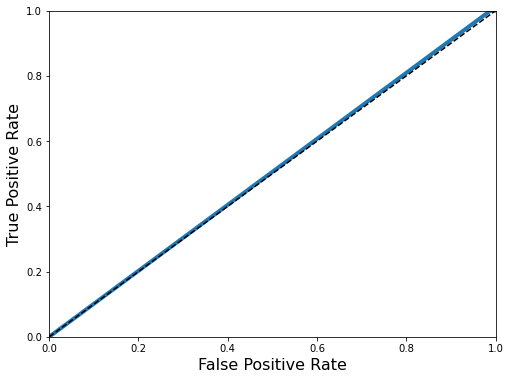


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 1.7079

ACCURACY: 0.49

F1 SCORE: 0.65


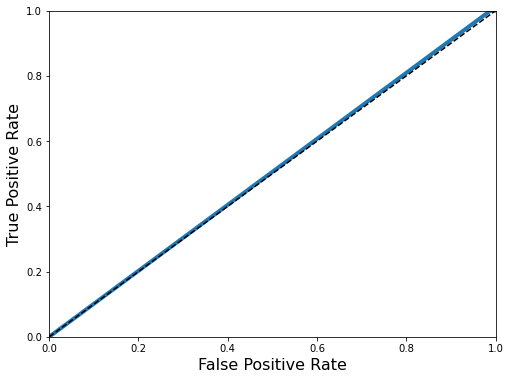

In [ ]:
base_model = rf
unlabel_percent = [0.0,0.1,0.2,0.5,0.9,0.95]
score = []
timer = []

for unlabelled in unlabel_percent:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    X_lab,y_lab = Unlabel(X_train2,y_train2,unlabel_percent=unlabelled,split=False)
    start = time.time() # Start the Timer
    Semi = SemiBoostClassifier(base_model)
    Semi.fit(X_lab,y_lab,similarity_kernel='rbf')
    y_pred = Semi.predict(X_test2)
    end = time.time() # End the Timer
    
    score.append(f1_score(y_test2,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test2,y_pred,start,end)

In [ ]:
Semi_D2 = pd.DataFrame(score,columns=['Semi_D2'],index=["0%","10%","20%","50%","90%","95%"])
time_Semi_D2 = pd.DataFrame(timer,columns=['time_Semi_D2'],index=["0%","10%","20%","50%","90%","95%"])
result2 = result2.merge(Semi_D2,left_index=True,right_index=True)
time2 = time2.merge(time_Semi_D2,left_index=True,right_index=True)

In [ ]:
result2

Semi_D1  Semi_D1_Over  Semi_D1_Under   Semi_D2
0%   0.625743      0.642682       0.630284  0.886191
10%  0.612355      0.600712       0.598802  0.884273
20%  0.587041      0.484879       0.498725  0.869930
50%  0.349757      0.269604       0.274462  0.731982
90%  0.266223      0.267853       0.267853  0.654582
95%  0.268545      0.267853       0.267853  0.654582

### Dataset 3

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=3,splitter='best',random_state=42)
rf = RandomForestClassifier(criterion='gini',max_depth=4,n_estimators=60,random_state=42)
svm = SVC(gamma='scale',degree=8,kernel='rbf',C=1,random_state=42,probability=True)
knn = KNeighborsClassifier(n_neighbors=5,algorithm='auto',p=1)
mlp = MLPClassifier(max_iter=300,solver='adam',learning_rate='adaptive',activation='logistic',verbose='true',batch_size=32,hidden_layer_sizes=(20,20,20),random_state=42)
gb = GradientBoostingClassifier(learning_rate=0.1,loss='exponential',n_estimators=80,subsample=0.5,criterion='mse',max_depth=20,max_features='sqrt')


### Printing Unlabel Performance for Dataset 3 [Semi-Boost]


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.0136

ACCURACY: 0.81

F1 SCORE: 0.83


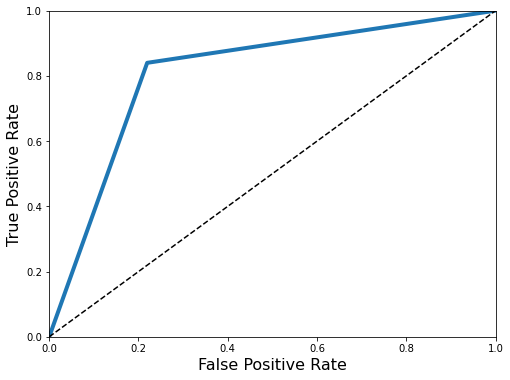


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.0316

ACCURACY: 0.84

F1 SCORE: 0.85


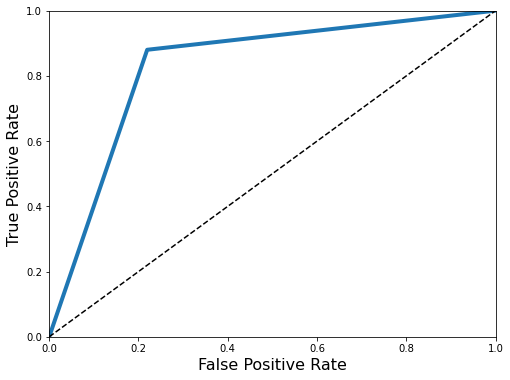


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.0411

ACCURACY: 0.81

F1 SCORE: 0.84


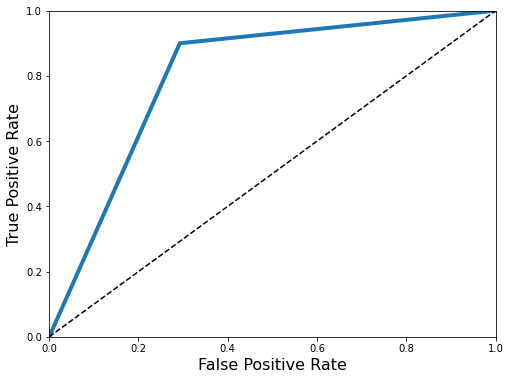


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.0594

ACCURACY: 0.67

F1 SCORE: 0.76


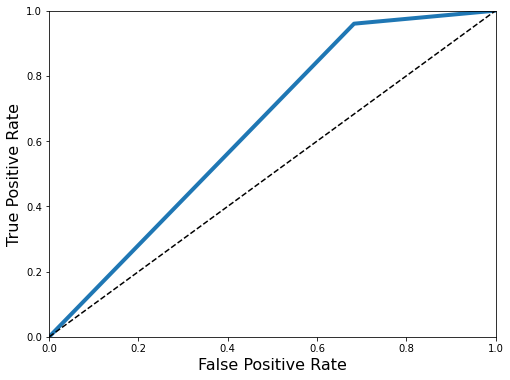


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.0610

ACCURACY: 0.55

F1 SCORE: 0.71


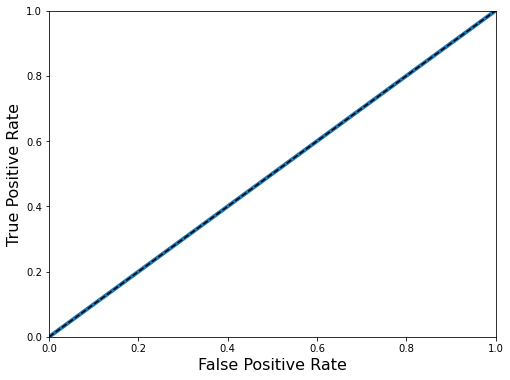


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.0619

ACCURACY: 0.55

F1 SCORE: 0.71


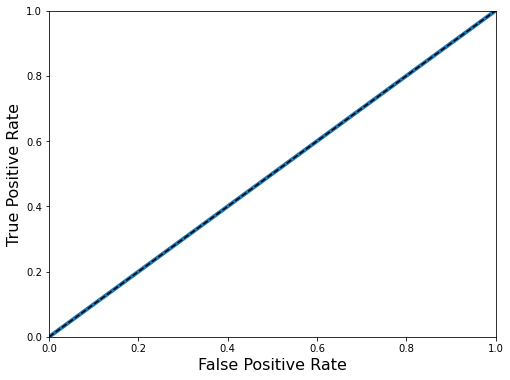

In [ ]:
base_model = knn
unlabel_percent = [0.0,0.1,0.2,0.5,0.9,0.95]
score = []
timer = []

for unlabelled in unlabel_percent:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    X_lab,y_lab = Unlabel(X_train3,y_train3,unlabel_percent=unlabelled,split=False)
    start = time.time() # Start the Timer
    Semi = SemiBoostClassifier(base_model)
    Semi.fit(X_lab,y_lab,similarity_kernel='rbf')
    y_pred = Semi.predict(X_test3)
    end = time.time() # End the Timer
    
    score.append(f1_score(y_test3,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test3,y_pred,start,end)

In [ ]:
Semi_D3 = pd.DataFrame(score,columns=['Semi_D3'],index=["0%","10%","20%","50%","90%","95%"])
time_Semi_D3 = pd.DataFrame(timer,columns=['time_Semi_D3'],index=["0%","10%","20%","50%","90%","95%"])
result2 = result2.merge(Semi_D3,left_index=True,right_index=True)
time2 = time2.merge(time_Semi_D3,left_index=True,right_index=True)

In [ ]:
result2

Semi_D1  Semi_D1_Over  Semi_D1_Under   Semi_D2   Semi_D3
0%   0.625743      0.642682       0.630284  0.886191  0.831683
10%  0.612355      0.600712       0.598802  0.884273  0.854369
20%  0.587041      0.484879       0.498725  0.869930  0.841121
50%  0.349757      0.269604       0.274462  0.731982  0.761905
90%  0.266223      0.267853       0.267853  0.654582  0.709220
95%  0.268545      0.267853       0.267853  0.654582  0.709220

In [ ]:
result2.to_csv('data/result_Semi.csv')

In [ ]:
time2.to_csv('data/time_Semi.csv')

In [ ]:
dataset1 = list(result2.iloc[:,0])
dataset1_over = list(result2.iloc[:,1])
dataset1_under = list(result2.iloc[:,2])
dataset2 = list(result2.iloc[:,3])
dataset3 = list(result2.iloc[:,4])

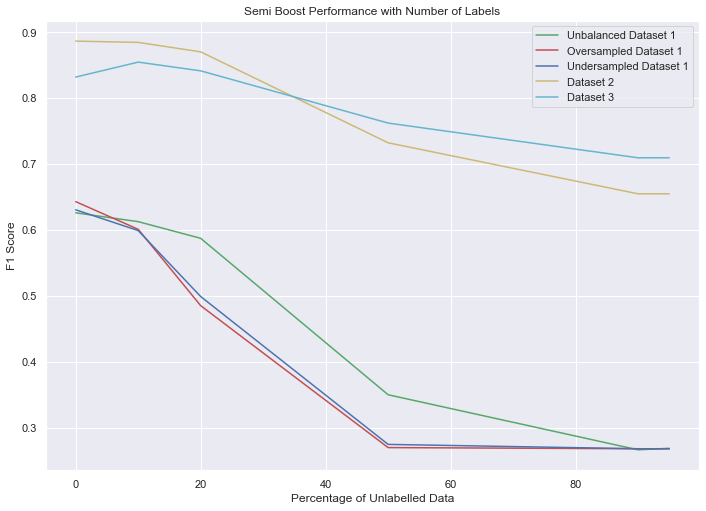

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
epochs = [0,10,20,50,90,95]
plt.plot(epochs, dataset1, 'g', label='Unbalanced Dataset 1')
plt.plot(epochs, dataset1_over, 'r', label='Oversampled Dataset 1')
plt.plot(epochs, dataset1_under, 'b', label='Undersampled Dataset 1')
plt.plot(epochs, dataset2, 'y', label='Dataset 2')
plt.plot(epochs, dataset3, 'c', label='Dataset 3')
plt.title('Semi Boost Performance with Number of Labels')
plt.xlabel('Percentage of Unlabelled Data')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Semisupervised Ensemble 
<img src="files/Ensemble.png" style="height:400px; width:550px;" align="left"/>

In [ ]:
class Ensemble():
    def __init__(self,cl1,cl2,cl3):
        self.ensemble = VotingClassifier(estimators=[ ('cl1', cl1),('cl2', cl2),('cl3', cl3)], voting='hard')

    def fit(self,X_lab,y_lab,X_ulab,split_percent=0.25):
        if(X_ulab is None):
            self.ensemble.fit(X_lab,y_lab)
            return
        while len(X_ulab)>4:

            self.ensemble.fit(X_lab,y_lab)
            y_pred = self.ensemble.predict(X_ulab)

            X_ulab,X_pseudo,y_ulab,y_pseudo = train_test_split(X_ulab,y_pred,test_size=split_percent,random_state=42)

            X_lab = np.append(X_lab,X_pseudo,axis=0)
            y_lab = np.append(y_lab,y_pseudo)

    def predict(self,X):
        return self.ensemble.predict(X)

### Dataset 1 Unbalanced [Ensemble]


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 19.3527

ACCURACY: 0.89

F1 SCORE: 0.62


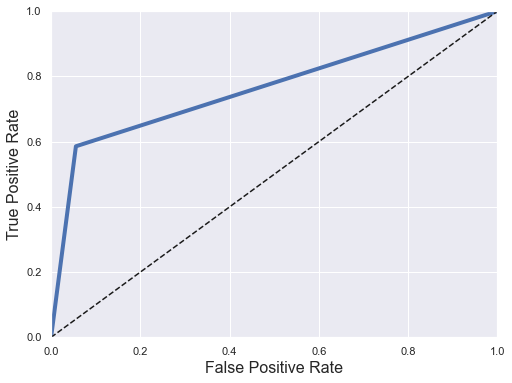


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 375.1114

ACCURACY: 0.89

F1 SCORE: 0.60


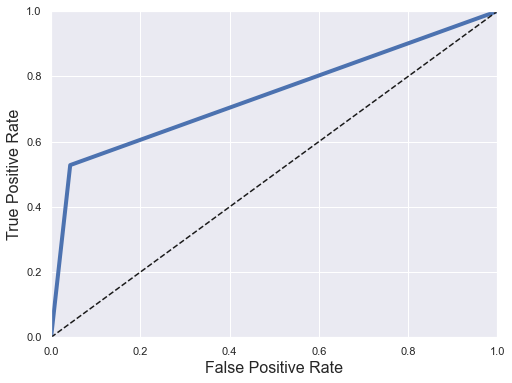


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 381.4070

ACCURACY: 0.89

F1 SCORE: 0.63


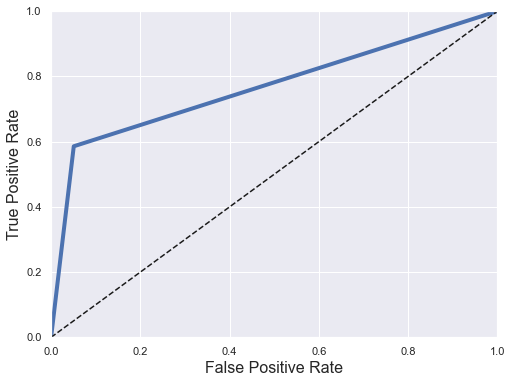


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 386.9299

ACCURACY: 0.90

F1 SCORE: 0.63


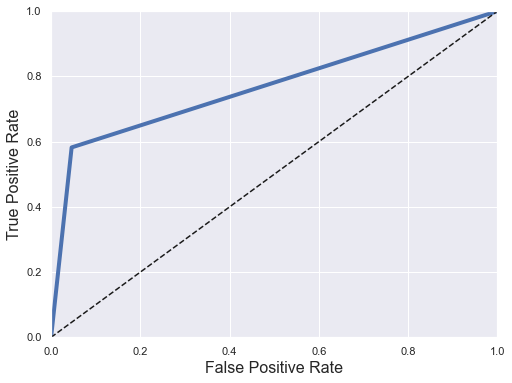


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 244.2698

ACCURACY: 0.89

F1 SCORE: 0.58


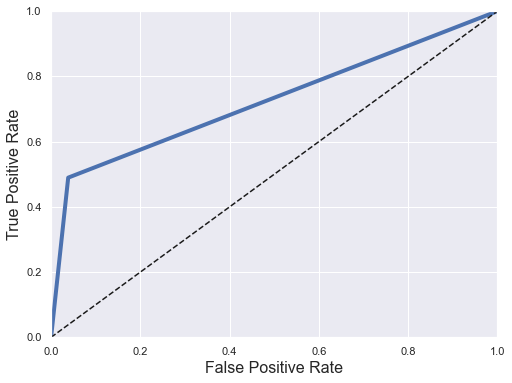


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 188.0373

ACCURACY: 0.88

F1 SCORE: 0.56


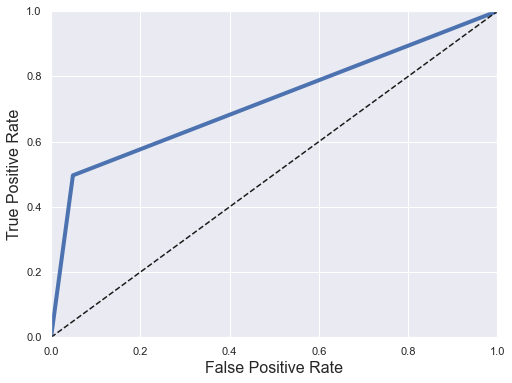

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=3,splitter='best',random_state=42)
svm = SVC(gamma='auto',degree=2,kernel='rbf',C=10)
mlp = MLPClassifier(max_iter=300,solver='adam',learning_rate='adaptive',activation='relu',batch_size=128,hidden_layer_sizes=(100,100),warm_start=True,random_state=42)

score = []
timer = []

ensemble = Ensemble(dt,svm,mlp)
#Modifying the test data the same as the train data
for unlabelled in [0.0,0.1,0.2,0.5,0.9,0.95]:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    start = time.time() # Start the Timer
    X_lab,X_ulab,y_lab = Unlabel(X_train1,y_train1,unlabel_percent=unlabelled,split=True)
    ensemble.fit(X_lab,y_lab,X_ulab,split_percent=0.25)
    y_pred = ensemble.predict(X_test1)
    end = time.time() # End the Timer
    
    score.append(f1_score(y_test1,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test1,y_pred,start,end)

In [ ]:
Ensemble_D1 = pd.DataFrame(score,columns=['Ensemble_D1'],index=["0%","10%","20%","50%","90%","95%"])
time_Ensemble_D1 = pd.DataFrame(timer,columns=['time_Ensemble_D1'],index=["0%","10%","20%","50%","90%","95%"])

In [ ]:
Ensemble_D1

Ensemble_D1
0%      0.619796
10%     0.599206
20%     0.628518
50%     0.634890
90%     0.576132
95%     0.562934

### Dataset 1 Over-Sampled [Ensemble]


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 35.0949

ACCURACY: 0.87

F1 SCORE: 0.63


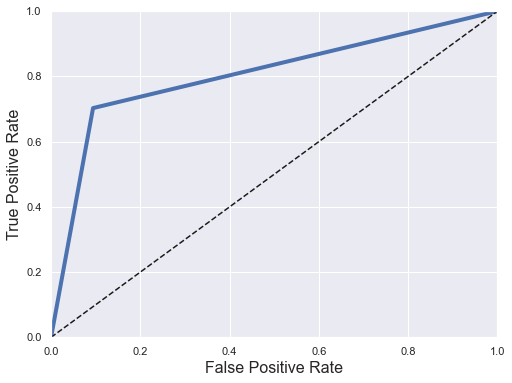


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 658.5185

ACCURACY: 0.87

F1 SCORE: 0.63


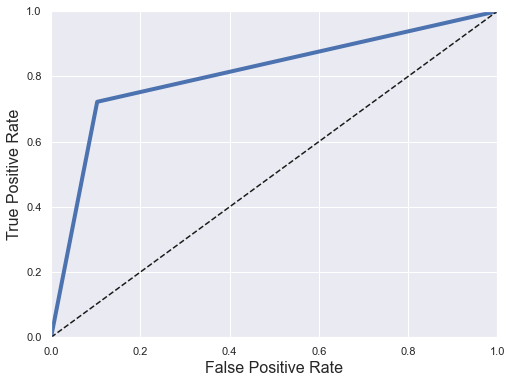


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 752.3668

ACCURACY: 0.87

F1 SCORE: 0.64


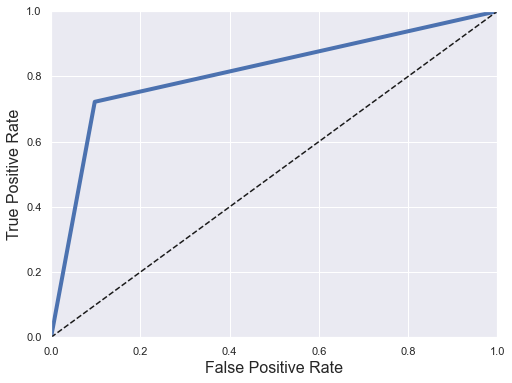


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 677.2410

ACCURACY: 0.87

F1 SCORE: 0.64


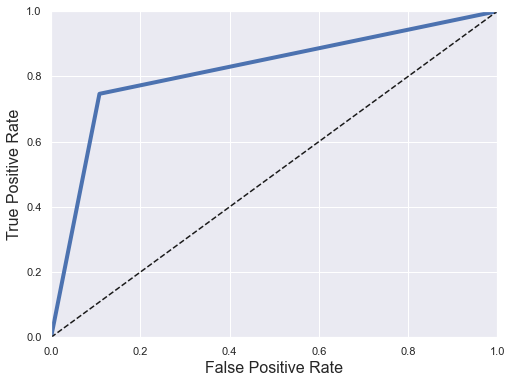


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 469.2728

ACCURACY: 0.85

F1 SCORE: 0.63


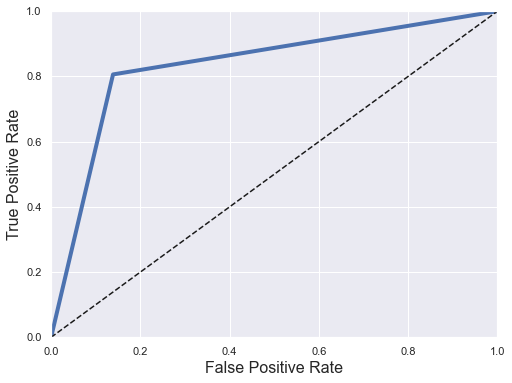


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 390.7166

ACCURACY: 0.86

F1 SCORE: 0.63


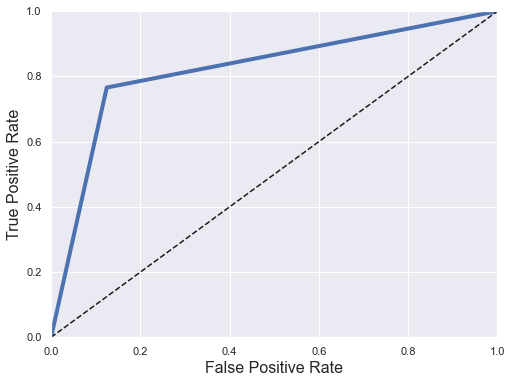

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=3,splitter='best',random_state=42)
svm = SVC(gamma='auto',degree=2,kernel='rbf',C=10)
mlp = MLPClassifier(max_iter=300,solver='adam',learning_rate='adaptive',activation='relu',batch_size=128,hidden_layer_sizes=(100,100),warm_start=True,random_state=42)

score = []
timer = []

ensemble = Ensemble(dt,svm,mlp)
#Modifying the test data the same as the train data
for unlabelled in [0.0,0.1,0.2,0.5,0.9,0.95]:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    start = time.time() # Start the Timer
    X_lab,X_ulab,y_lab = Unlabel(X_train1_over,y_train1_over,unlabel_percent=unlabelled,split=True)
    ensemble.fit(X_lab,y_lab,X_ulab,split_percent=0.25)
    y_pred = ensemble.predict(X_test1)
    end = time.time() # End the Timer
    
    score.append(f1_score(y_test1,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test1,y_pred,start,end)

In [ ]:
Ensemble_D1_over = pd.DataFrame(score,columns=['Ensemble_D1_over'],index=["0%","10%","20%","50%","90%","95%"])
time_Ensemble_D1_over = pd.DataFrame(timer,columns=['time_Ensemble_D1_over'],index=["0%","10%","20%","50%","90%","95%"])
result3 = Ensemble_D1.merge(Ensemble_D1_over,left_index=True,right_index=True)
time3 = time_Ensemble_D1.merge(time_Ensemble_D1_over,left_index=True,right_index=True)

In [ ]:
result3

Ensemble_D1  Ensemble_D1_over
0%      0.619796          0.634069
10%     0.599206          0.631498
20%     0.628518          0.639814
50%     0.634890          0.638266
90%     0.576132          0.628494
95%     0.562934          0.625714

### Dataset 1 Under-Sampled [Ensemble]


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 10.4533

ACCURACY: 0.88

F1 SCORE: 0.65


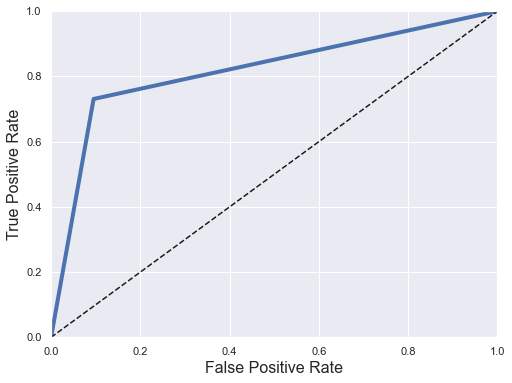


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 145.5693

ACCURACY: 0.87

F1 SCORE: 0.64


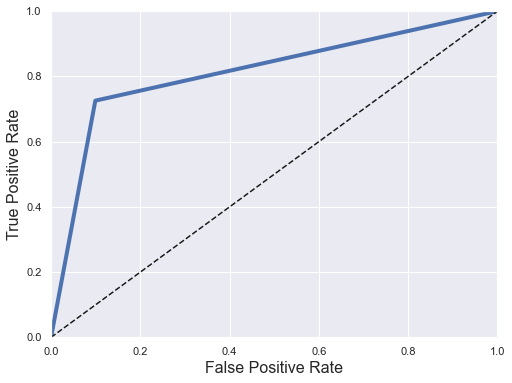


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 162.1337

ACCURACY: 0.88

F1 SCORE: 0.65


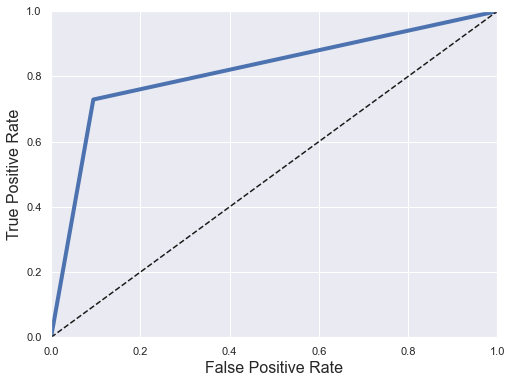


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 160.0880

ACCURACY: 0.88

F1 SCORE: 0.64


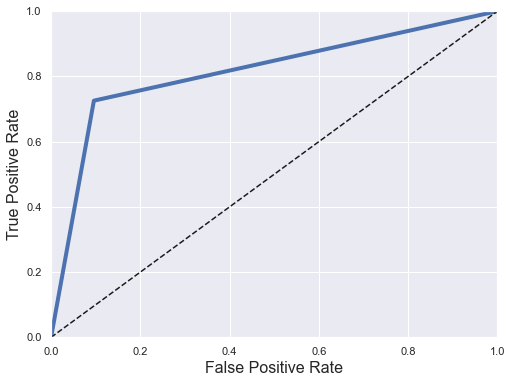


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 123.3486

ACCURACY: 0.87

F1 SCORE: 0.61


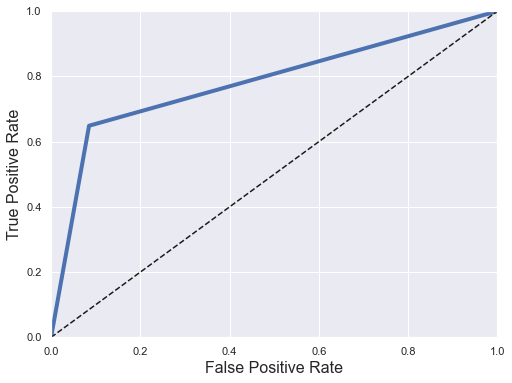


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 100.5083

ACCURACY: 0.88

F1 SCORE: 0.61


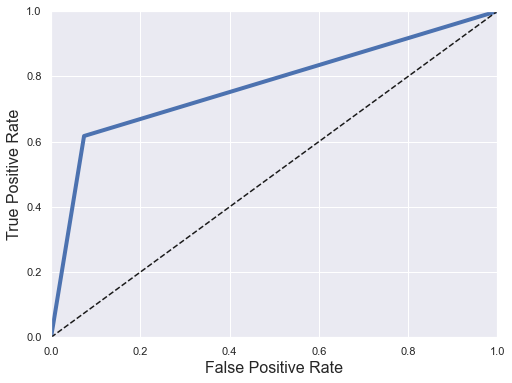

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=3,splitter='best',random_state=42)
svm = SVC(gamma='auto',degree=2,kernel='rbf',C=10)
mlp = MLPClassifier(max_iter=300,solver='adam',learning_rate='adaptive',activation='relu',batch_size=128,hidden_layer_sizes=(100,100),warm_start=True,random_state=42)

score = []
timer = []

ensemble = Ensemble(dt,svm,mlp)
#Modifying the test data the same as the train data
for unlabelled in [0.0,0.1,0.2,0.5,0.9,0.95]:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    start = time.time() # Start the Timer
    X_lab,X_ulab,y_lab = Unlabel(X_train1_under,y_train1_under,unlabel_percent=unlabelled,split=True)
    ensemble.fit(X_lab,y_lab,X_ulab,split_percent=0.25)
    y_pred = ensemble.predict(X_test1)
    end = time.time() # End the Timer
    
    score.append(f1_score(y_test1,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test1,y_pred,start,end)

In [ ]:
Ensemble_D1_under = pd.DataFrame(score,columns=['Ensemble_D1_under'],index=["0%","10%","20%","50%","90%","95%"])
time_Ensemble_D1_under = pd.DataFrame(timer,columns=['time_Ensemble_D1_under'],index=["0%","10%","20%","50%","90%","95%"])
result3 = result3.merge(Ensemble_D1_under,left_index=True,right_index=True)
time3 = time3.merge(time_Ensemble_D1_under,left_index=True,right_index=True)

In [ ]:
result3

Ensemble_D1  Ensemble_D1_over  Ensemble_D1_under
0%      0.619796          0.634069           0.649068
10%     0.599206          0.631498           0.639938
20%     0.628518          0.639814           0.649027
50%     0.634890          0.638266           0.644911
90%     0.576132          0.628494           0.613730
95%     0.562934          0.625714           0.610727

### Dataset 2 [Ensemble]


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.7338

ACCURACY: 0.90

F1 SCORE: 0.90


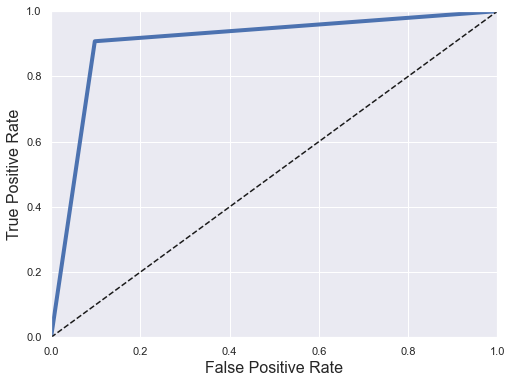


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 7.4407

ACCURACY: 0.91

F1 SCORE: 0.91


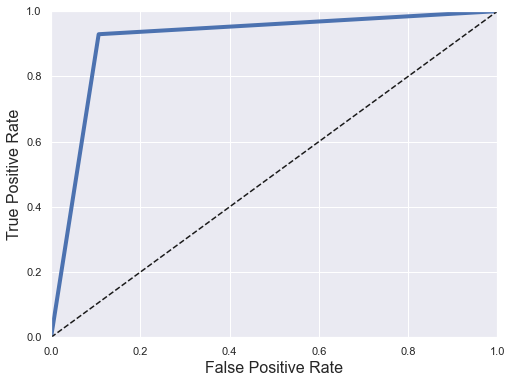


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 8.3005

ACCURACY: 0.89

F1 SCORE: 0.88


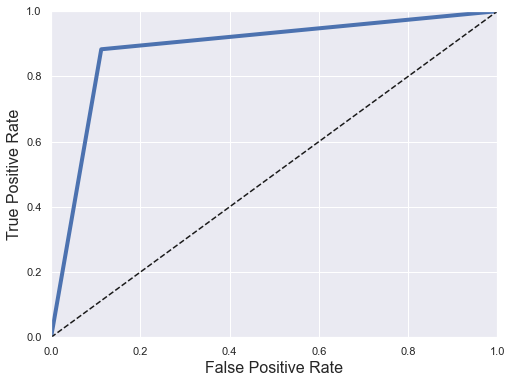


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 8.8198

ACCURACY: 0.90

F1 SCORE: 0.90


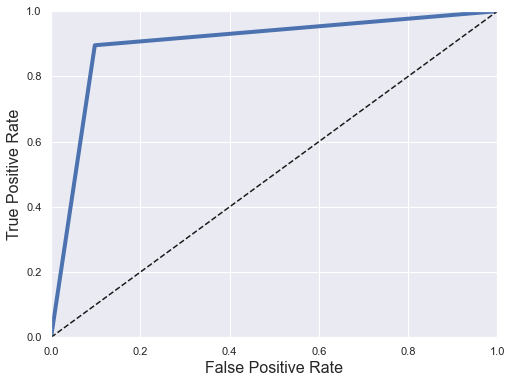


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 8.7649

ACCURACY: 0.86

F1 SCORE: 0.85


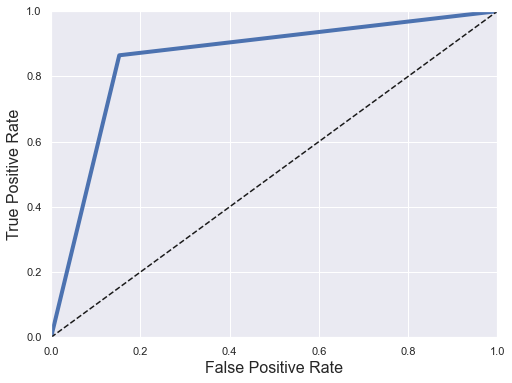


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 8.4525

ACCURACY: 0.83

F1 SCORE: 0.83


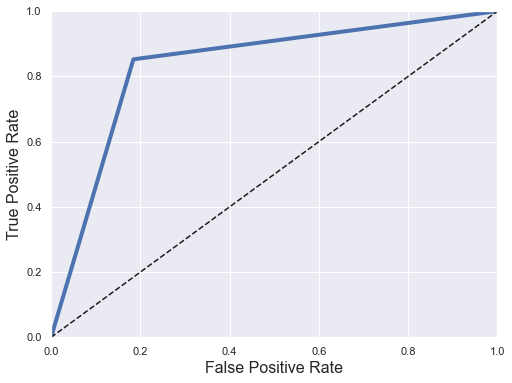

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=10,splitter='best',random_state=42)
rf = RandomForestClassifier(criterion='entropy',max_depth=100,n_estimators=60,random_state=42)
svm = SVC(gamma='auto',degree=6,kernel='rbf',C=20,random_state=42,probability=True)
knn = KNeighborsClassifier(n_neighbors=7,algorithm='auto',p=1)
mlp = MLPClassifier(max_iter=300,solver='adam',learning_rate='adaptive',activation='logistic',batch_size=64,hidden_layer_sizes=(30,30,30),random_state=42)
gb = GradientBoostingClassifier(learning_rate=0.5,loss='exponential',n_estimators=80,subsample=1,criterion='mse',max_depth=5,max_features='sqrt')
score = []
timer = []

ensemble = Ensemble(rf,svm,gb)
#Modifying the test data the same as the train data
for unlabelled in [0.0,0.1,0.2,0.5,0.9,0.95]:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    start = time.time() # Start the Timer
    X_lab,X_ulab,y_lab = Unlabel(X_train2,y_train2,unlabel_percent=unlabelled,split=True)
    ensemble.fit(X_lab,y_lab,X_ulab,split_percent=0.25)
    y_pred = ensemble.predict(X_test2)
    end = time.time() # End the Timer
    
    score.append(f1_score(y_test2,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test2,y_pred,start,end)

In [ ]:
Ensemble_D2 = pd.DataFrame(score,columns=['Ensemble_D2'],index=["0%","10%","20%","50%","90%","95%"])
time_Ensemble_D2 = pd.DataFrame(timer,columns=['time_Ensemble_D2'],index=["0%","10%","20%","50%","90%","95%"])
result3 = result3.merge(Ensemble_D2,left_index=True,right_index=True)
time3 = time3.merge(time_Ensemble_D2,left_index=True,right_index=True)

In [ ]:
result3

Ensemble_D1  Ensemble_D1_over  Ensemble_D1_under  Ensemble_D2
0%      0.619796          0.634069           0.649068     0.902141
10%     0.599206          0.631498           0.639938     0.909639
20%     0.628518          0.639814           0.649027     0.881720
50%     0.634890          0.638266           0.644911     0.895385
90%     0.576132          0.628494           0.613730     0.852807
95%     0.562934          0.625714           0.610727     0.831832

### Dataset 3 [Ensemble]


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 0.4892

ACCURACY: 0.81

F1 SCORE: 0.83


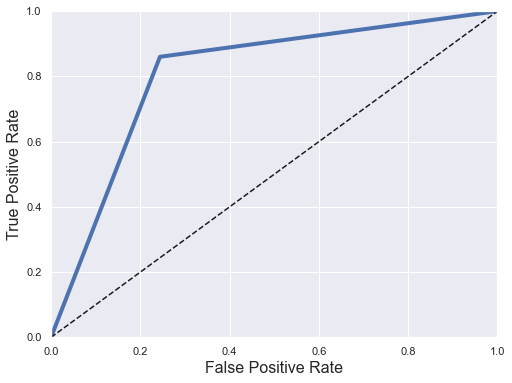


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 1.8247

ACCURACY: 0.84

F1 SCORE: 0.86


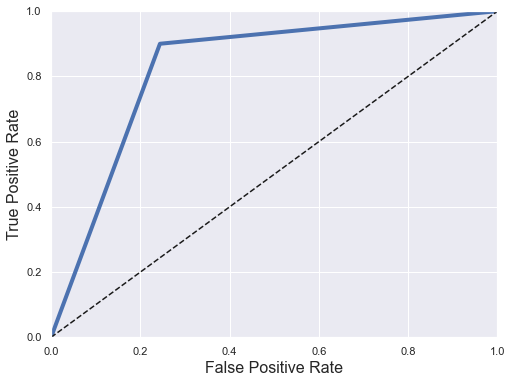


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 2.8310

ACCURACY: 0.81

F1 SCORE: 0.83


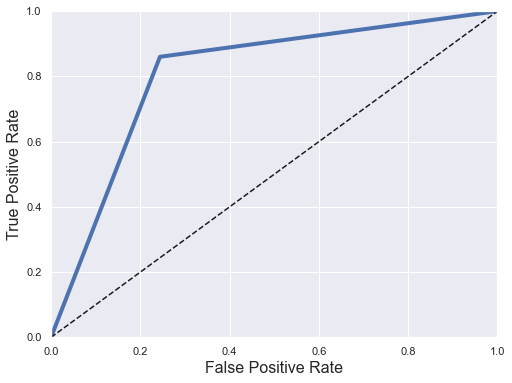


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 3.7857

ACCURACY: 0.85

F1 SCORE: 0.87


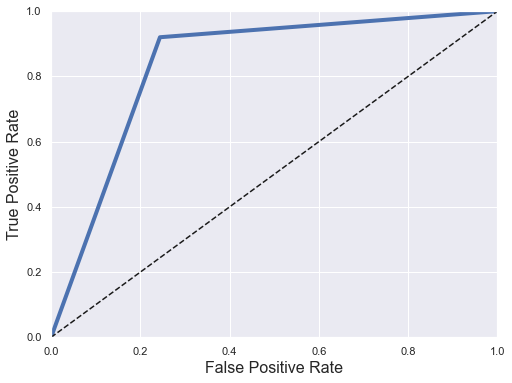


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 4.3226

ACCURACY: 0.78

F1 SCORE: 0.80


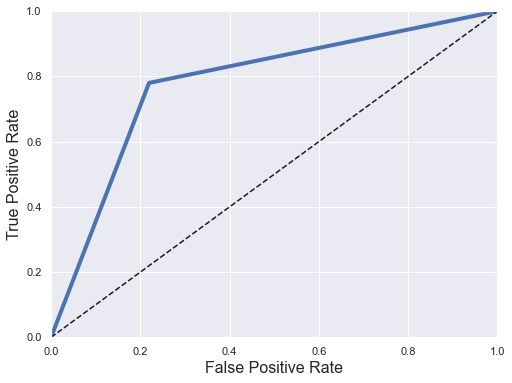


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 4.3687

ACCURACY: 0.78

F1 SCORE: 0.79


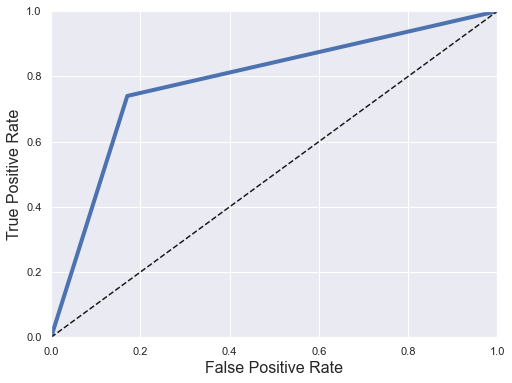

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=3,splitter='best',random_state=42)
rf = RandomForestClassifier(criterion='gini',max_depth=4,n_estimators=60,random_state=42)
svm = SVC(gamma='scale',degree=8,kernel='rbf',C=1,random_state=42,probability=True)
knn = KNeighborsClassifier(n_neighbors=5,algorithm='auto',p=1)
gb = GradientBoostingClassifier(learning_rate=0.1,loss='exponential',n_estimators=80,subsample=0.5,criterion='mse',max_depth=20,max_features='sqrt')
score = []
timer = []

ensemble = Ensemble(svm,mlp,rf)
#Modifying the test data the same as the train data
for unlabelled in [0.0,0.1,0.2,0.5,0.9,0.95]:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    start = time.time() # Start the Timer
    X_lab,X_ulab,y_lab = Unlabel(X_train3,y_train3,unlabel_percent=unlabelled,split=True)
    ensemble.fit(X_lab,y_lab,X_ulab)
    y_pred = ensemble.predict(X_test3)
    end = time.time() # End the Timer
    
    score.append(f1_score(y_test3,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test3,y_pred,start,end)

In [ ]:
Ensemble_D3 = pd.DataFrame(score,columns=['Ensemble_D3'],index=["0%","10%","20%","50%","90%","95%"])
time_Ensemble_D3 = pd.DataFrame(timer,columns=['time_Ensemble_D3'],index=["0%","10%","20%","50%","90%","95%"])
result3 = result3.merge(Ensemble_D3,left_index=True,right_index=True)
time3 = time3.merge(time_Ensemble_D3,left_index=True,right_index=True)

In [ ]:
result3

Ensemble_D1  Ensemble_D1_over  Ensemble_D1_under  Ensemble_D2  \
0%      0.619796          0.634069           0.649068     0.902141   
10%     0.599206          0.631498           0.639938     0.909639   
20%     0.628518          0.639814           0.649027     0.881720   
50%     0.634890          0.638266           0.644911     0.895385   
90%     0.576132          0.628494           0.613730     0.852807   
95%     0.562934          0.625714           0.610727     0.831832   

     Ensemble_D3  
0%      0.834951  
10%     0.857143  
20%     0.834951  
50%     0.867925  
90%     0.795918  
95%     0.787234

In [ ]:
result3.to_csv('data/result_Ensemble.csv')

In [ ]:
time3.to_csv('data/time_Ensemble.csv')

In [ ]:
dataset1 = list(result3.iloc[:,0])
dataset1_over = list(result3.iloc[:,1])
dataset1_under = list(result3.iloc[:,2])
dataset2 = list(result3.iloc[:,3])
dataset3 = list(result3.iloc[:,4])

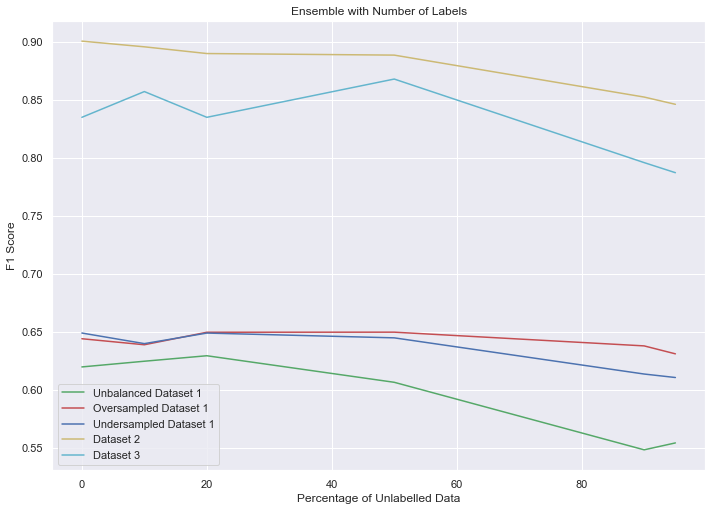

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
epochs = [0,10,20,50,90,95]
plt.plot(epochs, dataset1, 'g', label='Unbalanced Dataset 1')
plt.plot(epochs, dataset1_over, 'r', label='Oversampled Dataset 1')
plt.plot(epochs, dataset1_under, 'b', label='Undersampled Dataset 1')
plt.plot(epochs, dataset2, 'y', label='Dataset 2')
plt.plot(epochs, dataset3, 'c', label='Dataset 3')
plt.title('Ensemble with Number of Labels')
plt.xlabel('Percentage of Unlabelled Data')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Unsupervised Pre-Training
<img src="files/Pretraining.png" style="height:400px; width:550px;" align="left"/>

In [ ]:
def UnsupervisedPretrain(X,batch_size,verbose=0):
    X_train,X_val= train_test_split(X,test_size=0.2,random_state=42)

    n_inputs = X_train.shape[1]
    # define encoder
    visible = Input(shape=(n_inputs,))
    # encoder level 1
    encoder = Dense(n_inputs*2)(visible)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)
    # encoder level 2
    encoder = Dense(n_inputs)(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = LeakyReLU()(encoder)
    # bottleneck
    n_bottleneck = round(float(n_inputs) / 2.0)
    bottleneck = Dense(n_bottleneck)(encoder)
    # define decoder, level 1
    decoder = Dense(n_inputs)(bottleneck)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU()(decoder)
    # decoder level 2
    decoder = Dense(n_inputs*2)(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = LeakyReLU()(decoder)
    # output layer
    output = Dense(n_inputs, activation='linear')(decoder)
    # define autoencoder model
    model = Model(inputs=visible, outputs=output)
    # compile autoencoder model
    model.compile(optimizer='adam', loss='mse')

    #Training the Auto encoder
    model.fit(X_train, X_train, epochs=200, batch_size=batch_size, verbose=verbose, validation_data=(X_val,X_val))

    # Removing the decoder
    encoder = Model(inputs=visible, outputs=bottleneck)

    return encoder

### Dataset 1 Unbalanced

In [ ]:
encoder = UnsupervisedPretrain(X_train1,batch_size=64,verbose=0)


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 94.9874

ACCURACY: 0.88

F1 SCORE: 0.53


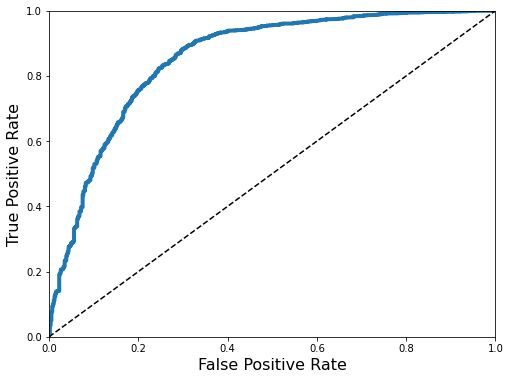


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 92.2360

ACCURACY: 0.89

F1 SCORE: 0.56


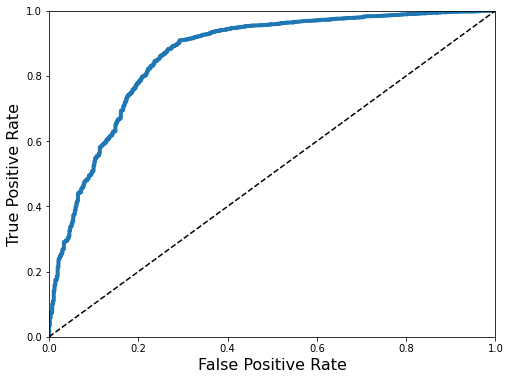


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 90.6944

ACCURACY: 0.88

F1 SCORE: 0.53


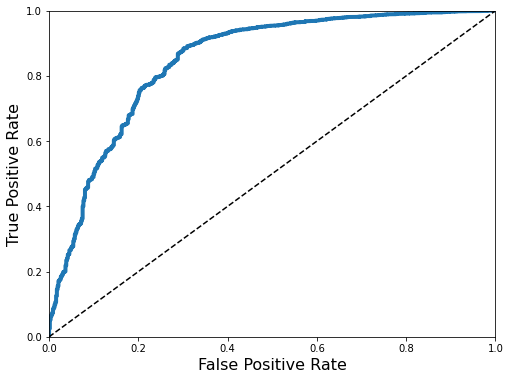


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 73.8921

ACCURACY: 0.88

F1 SCORE: 0.53


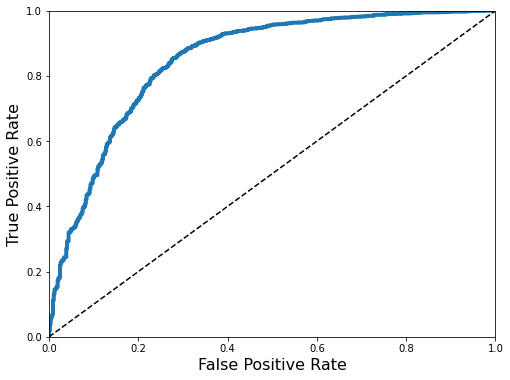


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 69.9842

ACCURACY: 0.87

F1 SCORE: 0.51


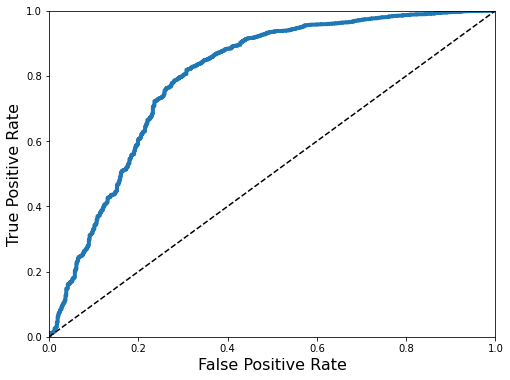


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 83.5687

ACCURACY: 0.86

F1 SCORE: 0.44


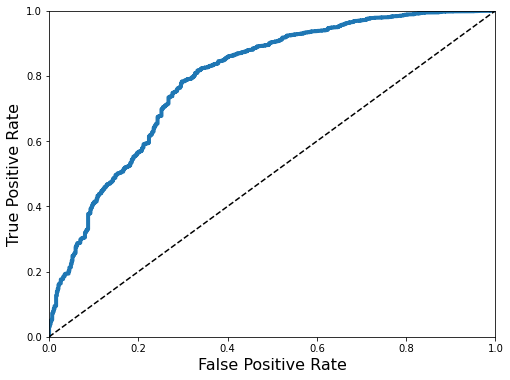

In [ ]:
svm = SVC(gamma='auto',degree=2,kernel='rbf',C=10,random_state=42,probability=True)
score = []
timer = []

for unlabelled in [0.0,0.1,0.2,0.5,0.9,0.95]:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    start = time.time() # Star the Timer
    encoder = UnsupervisedPretrain(X_train1,batch_size=64,verbose=0) # Training the encoder
    X_test = encoder(X_test1) #Modifying the test data the same as the train data
    
    X_lab,X_ulab,y_lab = Unlabel(X_train1,y_train1,unlabel_percent=unlabelled,split=True)
    X_lab = encoder.predict(X_lab)
    svm.fit(X_lab,y_lab)
    y_pred = svm.predict(X_test)
    end = time.time() # End the Timer

    y_pred_prob = svm.predict_proba(X_test)
    score.append(f1_score(y_test1,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test1,y_pred,start,end,y_pred_prob)

In [ ]:
UP_D1 = pd.DataFrame(score,columns=['UP_D1'],index=["0%","10%","20%","50%","90%","95%"])
time_UP_D1 = pd.DataFrame(timer,columns=['time_UP_D1'],index=["0%","10%","20%","50%","90%","95%"])

In [ ]:
UP_D1

UP_D1
0%   0.530043
10%  0.563410
20%  0.532328
50%  0.530043
90%  0.508827
95%  0.442553

### Dataset 1 Over-Sampled


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 183.0055

ACCURACY: 0.84

F1 SCORE: 0.57


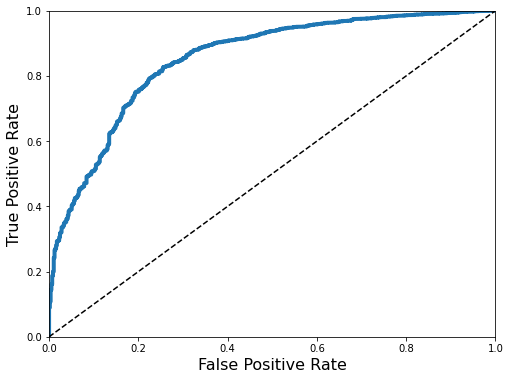


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 176.9928

ACCURACY: 0.85

F1 SCORE: 0.58


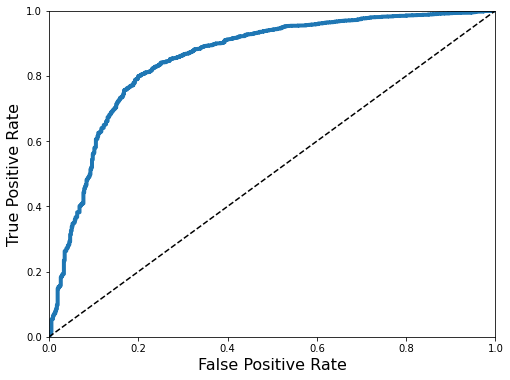


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 171.3491

ACCURACY: 0.83

F1 SCORE: 0.56


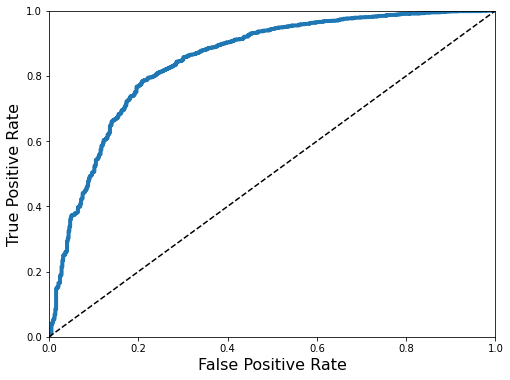


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 154.0720

ACCURACY: 0.84

F1 SCORE: 0.56


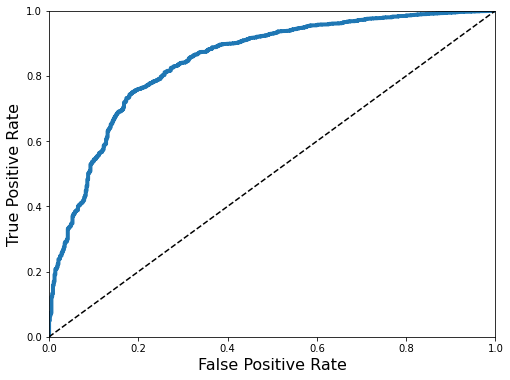


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 114.1924

ACCURACY: 0.82

F1 SCORE: 0.55


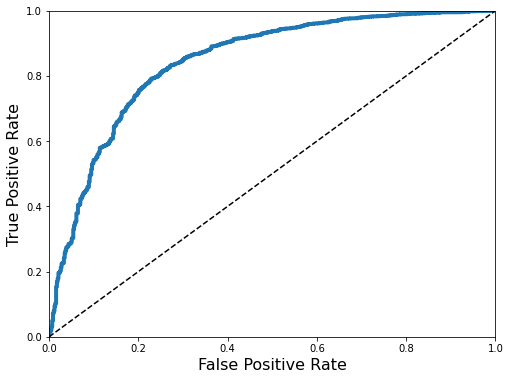


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 113.6828

ACCURACY: 0.79

F1 SCORE: 0.50


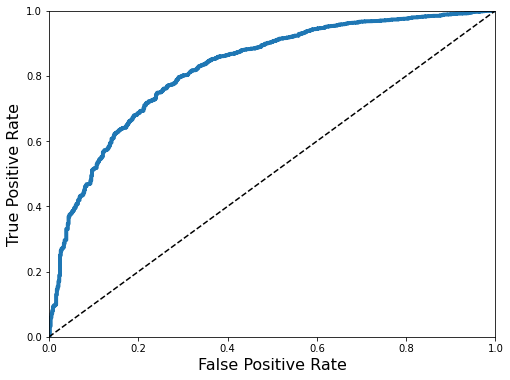

In [ ]:
svm = SVC(gamma='auto',degree=2,kernel='rbf',C=10,random_state=42,probability=True)
score = []
timer = []

for unlabelled in [0.0,0.1,0.2,0.5,0.9,0.95]:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    start = time.time() # Star the Timer
    encoder = UnsupervisedPretrain(X_train1_over,batch_size=64,verbose=0) # Training the encoder
    X_test = encoder(X_test1) #Modifying the test data the same as the train data
    
    X_lab,X_ulab,y_lab = Unlabel(X_train1_over,y_train1_over,unlabel_percent=unlabelled,split=True)
    X_lab = encoder.predict(X_lab)
    svm.fit(X_lab,y_lab)
    y_pred = svm.predict(X_test)
    end = time.time() # End the Timer

    y_pred_prob = svm.predict_proba(X_test)
    score.append(f1_score(y_test1,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test1,y_pred,start,end,y_pred_prob)

In [ ]:
UP_D1_Over = pd.DataFrame(score,columns=['UP_D1_Over'],index=["0%","10%","20%","50%","90%","95%"])
time_UP_D1_Over = pd.DataFrame(timer,columns=['time_UP_D1_Over'],index=["0%","10%","20%","50%","90%","95%"])
result4 = UP_D1.merge(UP_D1_Over,left_index=True,right_index=True)
time4 = time_UP_D1.merge(time_UP_D1_Over,left_index=True,right_index=True)

In [ ]:
result4

UP_D1  UP_D1_Over
0%   0.530043    0.573314
10%  0.563410    0.576426
20%  0.532328    0.562500
50%  0.530043    0.557971
90%  0.508827    0.548942
95%  0.442553    0.502506

### Dataset 1 Under-Sampled


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 46.1538

ACCURACY: 0.87

F1 SCORE: 0.61


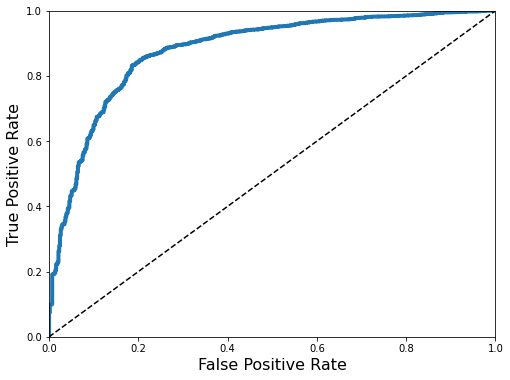


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 45.5651

ACCURACY: 0.87

F1 SCORE: 0.60


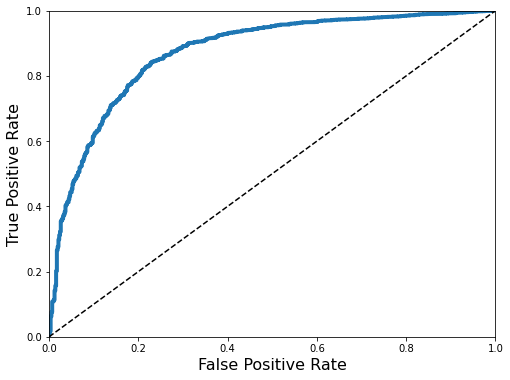


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 40.1521

ACCURACY: 0.87

F1 SCORE: 0.61


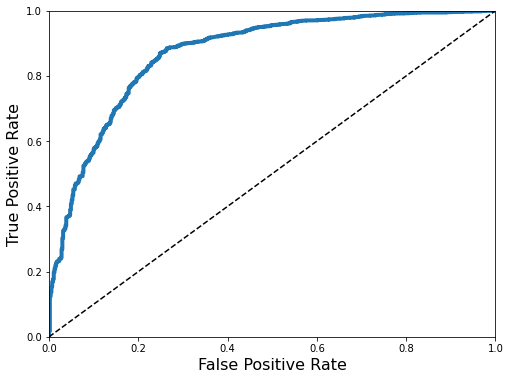


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 37.4665

ACCURACY: 0.87

F1 SCORE: 0.60


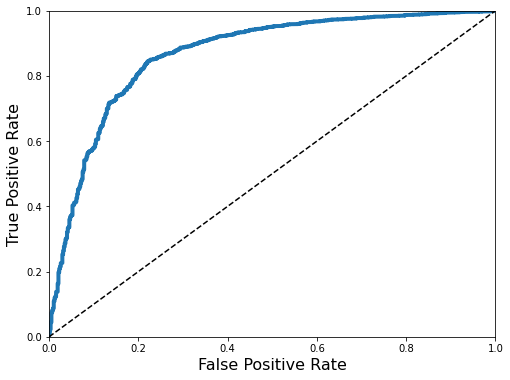


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 42.5899

ACCURACY: 0.84

F1 SCORE: 0.54


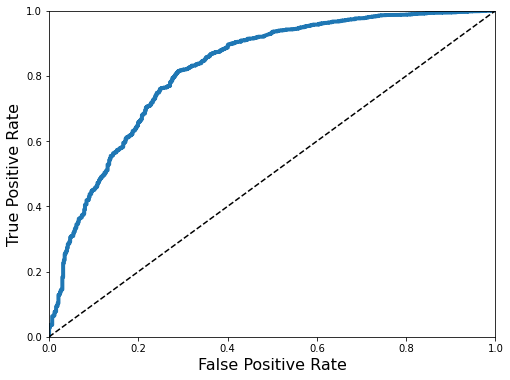


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 42.5933

ACCURACY: 0.81

F1 SCORE: 0.52


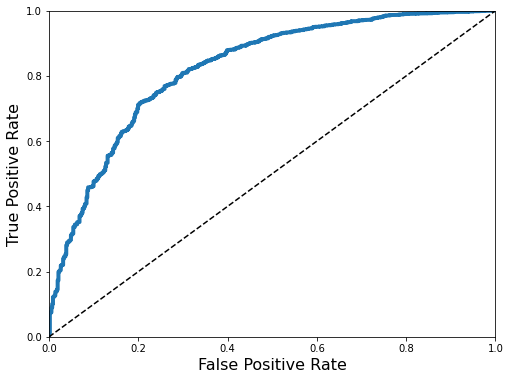

In [ ]:
svm = SVC(gamma='auto',degree=2,kernel='rbf',C=10,random_state=42,probability=True)
score = []
timer = []

for unlabelled in [0.0,0.1,0.2,0.5,0.9,0.95]:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    start = time.time()# Start the timer
    encoder = UnsupervisedPretrain(X_train1_under,batch_size=64,verbose=0) # Train the Autoencoder
    X_test = encoder(X_test1) #Modifying the test data the same as the train data

    X_lab,X_ulab,y_lab = Unlabel(X_train1_under,y_train1_under,unlabel_percent=unlabelled,split=True)
    X_lab = encoder.predict(X_lab)
    svm.fit(X_lab,y_lab)
    y_pred = svm.predict(X_test)
    end = time.time()# End the Timer

    y_pred_prob = svm.predict_proba(X_test)
    score.append(f1_score(y_test1,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test1,y_pred,start,end,y_pred_prob)

In [ ]:
UP_D1_Under = pd.DataFrame(score,columns=['UP_D1_Under'],index=["0%","10%","20%","50%","90%","95%"])
time_UP_D1_Under = pd.DataFrame(timer,columns=['time_UP_D1_Under'],index=["0%","10%","20%","50%","90%","95%"])
result4 = result4.merge(UP_D1_Under,left_index=True,right_index=True)
time4 = time4.merge(time_UP_D1_Under,left_index=True,right_index=True)

In [ ]:
result4

UP_D1  UP_D1_Over  UP_D1_Under
0%   0.530043    0.573314     0.614148
10%  0.563410    0.576426     0.604049
20%  0.532328    0.562500     0.610927
50%  0.530043    0.557971     0.601829
90%  0.508827    0.548942     0.537700
95%  0.442553    0.502506     0.518467

### Dataset 2

Dataset 2


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 23.6102

ACCURACY: 0.87

F1 SCORE: 0.86


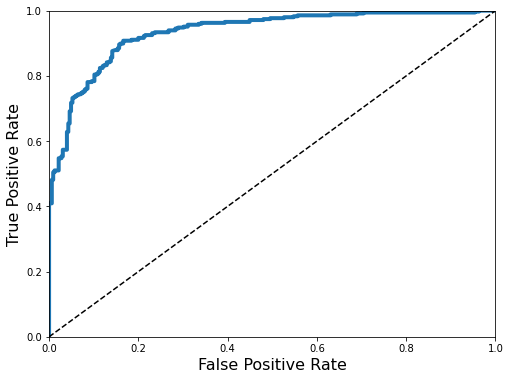


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 22.4972

ACCURACY: 0.85

F1 SCORE: 0.84


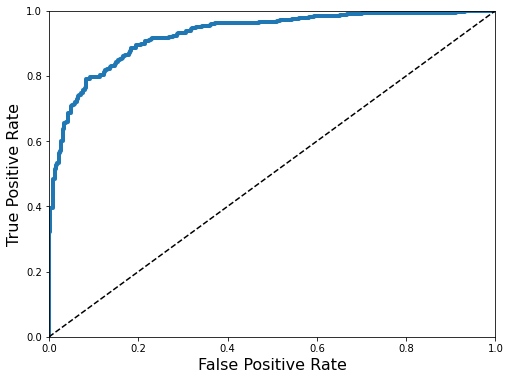


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 14.7520

ACCURACY: 0.87

F1 SCORE: 0.86


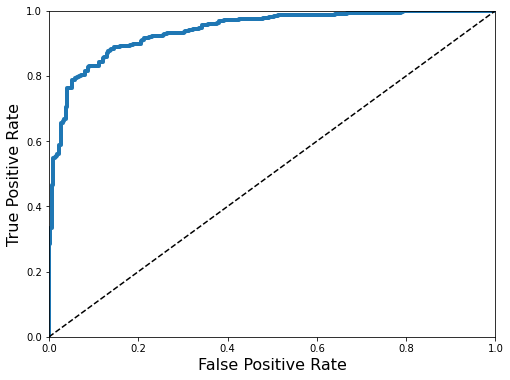


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 22.1919

ACCURACY: 0.84

F1 SCORE: 0.84


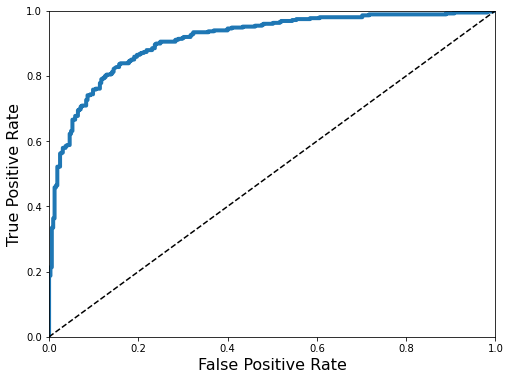


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 14.0275

ACCURACY: 0.78

F1 SCORE: 0.78


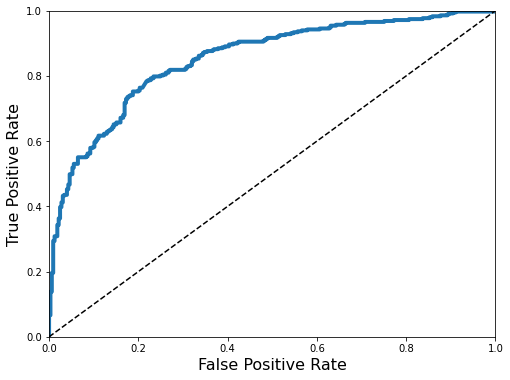


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 13.9942

ACCURACY: 0.76

F1 SCORE: 0.75


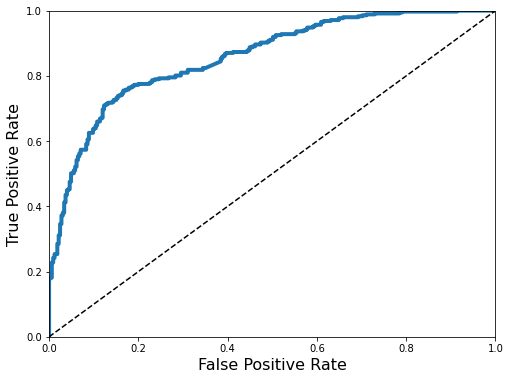

In [ ]:
svm = SVC(gamma='auto',degree=6,kernel='rbf',C=20,random_state=42,probability=True)
score = []
timer = []

for unlabelled in [0.0,0.1,0.2,0.5,0.9,0.95]:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    start = time.time()# Start the Timer
    encoder = UnsupervisedPretrain(X_train2,batch_size=128,verbose=0) # Training the Autoencoder
    X_test = encoder(X_test2) # Modifying the test data the same as the train data
    
    X_lab,X_ulab,y_lab = Unlabel(X_train2,y_train2,unlabel_percent=unlabelled,split=True)
    X_lab = encoder.predict(X_lab)
    svm.fit(X_lab,y_lab)
    y_pred = svm.predict(X_test)
    end = time.time()# End the Timer

    y_pred_prob = svm.predict_proba(X_test)
    score.append(f1_score(y_test2,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test2,y_pred,start,end,y_pred_prob)

In [ ]:
UP_D2 = pd.DataFrame(score,columns=['UP_D2'],index=["0%","10%","20%","50%","90%","95%"])
time_UP_D2 = pd.DataFrame(timer,columns=['time_UP_D2'],index=["0%","10%","20%","50%","90%","95%"])
result4 = result4.merge(UP_D2,left_index=True,right_index=True)
time4 = time4.merge(time_UP_D2,left_index=True,right_index=True)

In [ ]:
result4

UP_D1  UP_D1_Over  UP_D1_Under     UP_D2
0%   0.530043    0.573314     0.614148  0.862016
10%  0.563410    0.576426     0.604049  0.841463
20%  0.532328    0.562500     0.610927  0.864697
50%  0.530043    0.557971     0.601829  0.836090
90%  0.508827    0.548942     0.537700  0.781845
95%  0.442553    0.502506     0.518467  0.751572

### Dataset 3


*********************** 0.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 7.9357

ACCURACY: 0.80

F1 SCORE: 0.82


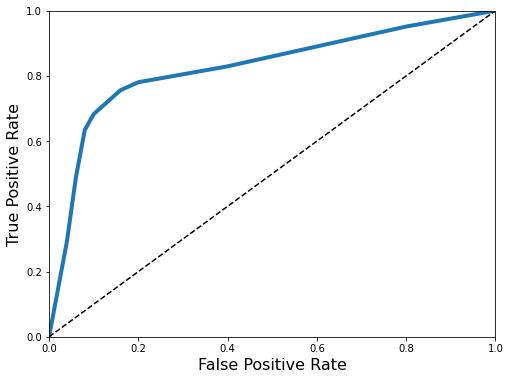


*********************** 10.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 8.0331

ACCURACY: 0.71

F1 SCORE: 0.72


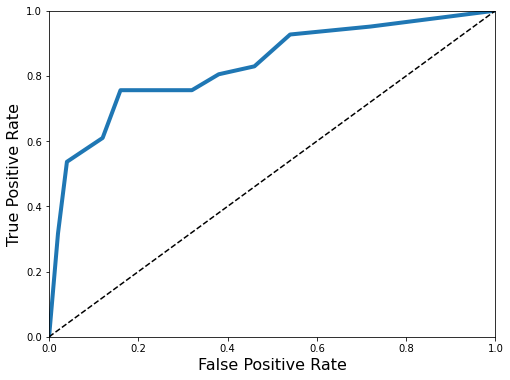


*********************** 20.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 7.9472

ACCURACY: 0.79

F1 SCORE: 0.82


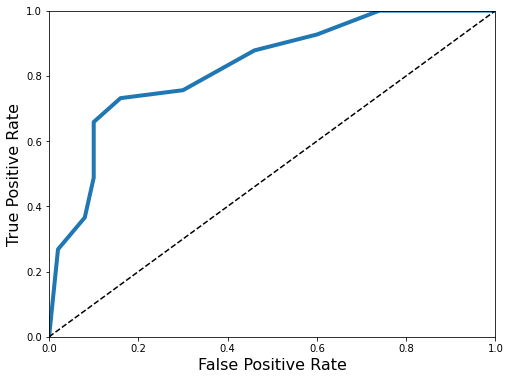


*********************** 50.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 7.9744

ACCURACY: 0.71

F1 SCORE: 0.75


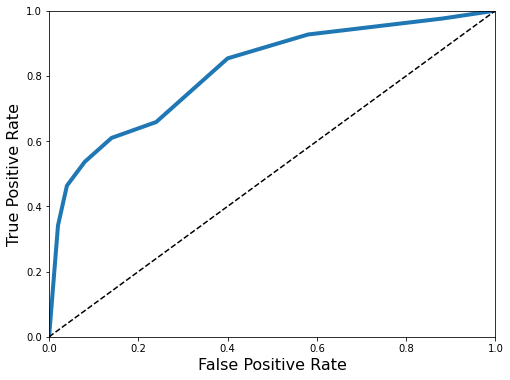


*********************** 90.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 7.6980

ACCURACY: 0.76

F1 SCORE: 0.80


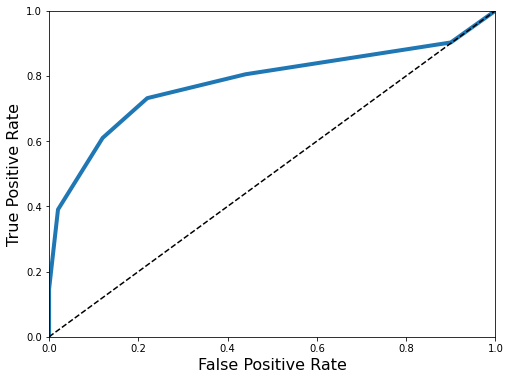


*********************** 95.0% Unlabelled ***********************

	PERFORMANCE EVALUATION

RUNNING TIME: 7.5776

ACCURACY: 0.53

F1 SCORE: 0.44


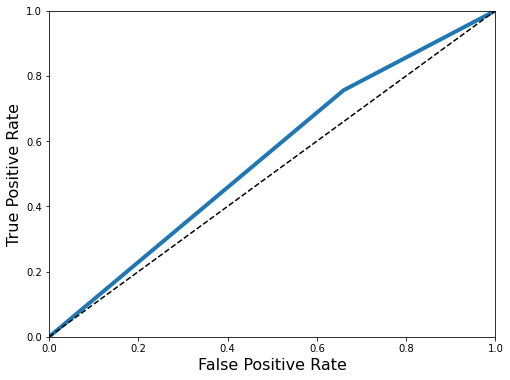

In [ ]:
knn = KNeighborsClassifier(n_neighbors=9,algorithm='auto',p=1)
score = []
timer = []

for unlabelled in [0.0,0.1,0.2,0.5,0.9,0.95]:
    print(f"\n*********************** {100*unlabelled}% Unlabelled ***********************")
    start = time.time() # Start the Timer
    encoder = UnsupervisedPretrain(X_train3,batch_size=64,verbose=0) # Training the Autoencoder
    X_test = encoder(X_test3) #Modifying the test data the same as the train data

    X_lab,X_ulab,y_lab = Unlabel(X_train3,y_train3,unlabel_percent=unlabelled,split=True)
    X_lab = encoder.predict(X_lab)
    knn.fit(X_lab,y_lab)
    y_pred = knn.predict(X_test)
    end = time.time() # End the Timer

    y_pred_prob = knn.predict_proba(X_test)
    score.append(f1_score(y_test3,y_pred))
    timer.append(end-start)
    PerformanceEvaluation(y_test3,y_pred,start,end,y_pred_prob)

In [ ]:
UP_D3 = pd.DataFrame(score,columns=['UP_D3'],index=["0%","10%","20%","50%","90%","95%"])
time_UP_D3 = pd.DataFrame(timer,columns=['time_UP_D3'],index=["0%","10%","20%","50%","90%","95%"])
result4 = result4.merge(UP_D3,left_index=True,right_index=True)
time4 = time4.merge(time_UP_D3,left_index=True,right_index=True)

In [ ]:
result4

UP_D1  UP_D1_Over  UP_D1_Under     UP_D2     UP_D3
0%   0.530043    0.573314     0.614148  0.862016  0.823529
10%  0.563410    0.576426     0.604049  0.841463  0.723404
20%  0.532328    0.562500     0.610927  0.864697  0.815534
50%  0.530043    0.557971     0.601829  0.836090  0.745098
90%  0.508827    0.548942     0.537700  0.781845  0.800000
95%  0.442553    0.502506     0.518467  0.751572  0.441558

In [ ]:
result4.to_csv('data/result_UP.csv')

In [ ]:
time4.to_csv('data/time_UP.csv')

In [ ]:
dataset1 = list(result4.iloc[:,0])
dataset1_over = list(result4.iloc[:,1])
dataset1_under = list(result4.iloc[:,2])
dataset2 = list(result4.iloc[:,3])
dataset3 = list(result4.iloc[:,4])

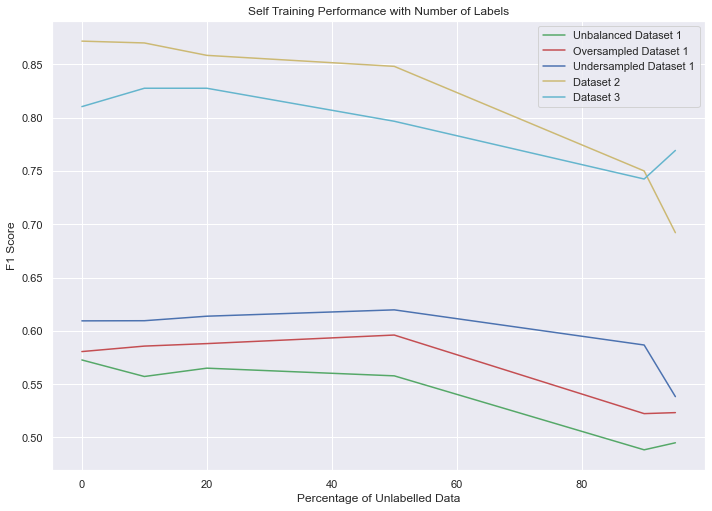

In [ ]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
epochs = [0,10,20,50,90,95]
plt.plot(epochs, dataset1, 'g', label='Unbalanced Dataset 1')
plt.plot(epochs, dataset1_over, 'r', label='Oversampled Dataset 1')
plt.plot(epochs, dataset1_under, 'b', label='Undersampled Dataset 1')
plt.plot(epochs, dataset2, 'y', label='Dataset 2')
plt.plot(epochs, dataset3, 'c', label='Dataset 3')
plt.title('Self Training Performance with Number of Labels')
plt.xlabel('Percentage of Unlabelled Data')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Statistical Tests

In [3]:
result1 = pd.read_csv('data/result_ST.csv')
result1.set_index("Unnamed: 0",inplace=True)
result2 = pd.read_csv('data/result_Semi.csv')
result2.set_index("Unnamed: 0",inplace=True)
result3 = pd.read_csv('data/result_Ensemble.csv')
result3.set_index("Unnamed: 0",inplace=True)
result4 = pd.read_csv('data/result_UP.csv')
result4.set_index("Unnamed: 0",inplace=True)

In [4]:
result1.index.rename("Level",inplace=True)
result2.index.rename("Level",inplace=True)
result3.index.rename("Level",inplace=True)
result4.index.rename("Level",inplace=True)

In [5]:
result1

ST_D1  ST_D1_Over  ST_D1_Under     ST_D2     ST_D3
Level                                                       
0%     0.625743    0.642682     0.630284  0.886191  0.831683
10%    0.626104    0.658517     0.649533  0.905263  0.831683
20%    0.610611    0.645367     0.634921  0.879389  0.843137
50%    0.596349    0.647719     0.657935  0.862500  0.878505
90%    0.509849    0.635724     0.620451  0.822981  0.857143
95%    0.435424    0.624055     0.625839  0.803625  0.807692

In [6]:
result2

Semi_D1  Semi_D1_Over  Semi_D1_Under   Semi_D2   Semi_D3
Level                                                           
0%     0.625743      0.642682       0.630284  0.886191  0.831683
10%    0.598921      0.612216       0.609097  0.878698  0.854369
20%    0.591156      0.497169       0.502834  0.860367  0.841121
50%    0.352068      0.269139       0.274424  0.732203  0.761905
90%    0.266414      0.267853       0.267853  0.654582  0.709220
95%    0.267672      0.267853       0.267853  0.653924  0.709220

In [7]:
result3

Ensemble_D1  Ensemble_D1_over  Ensemble_D1_under  Ensemble_D2  \
Level                                                                  
0%        0.619850          0.644148           0.649068     0.900602   
10%       0.624765          0.638953           0.639938     0.895706   
20%       0.629490          0.649731           0.649027     0.889908   
50%       0.606607          0.649808           0.644911     0.888550   
90%       0.548422          0.637978           0.613730     0.852410   
95%       0.554371          0.631130           0.610727     0.846154   

       Ensemble_D3  
Level               
0%        0.834951  
10%       0.857143  
20%       0.834951  
50%       0.867925  
90%       0.795918  
95%       0.787234

In [8]:
result4

UP_D1  UP_D1_Over  UP_D1_Under     UP_D2     UP_D3
Level                                                       
0%     0.572641    0.580508     0.609325  0.871795  0.810345
10%    0.557127    0.585643     0.609463  0.870091  0.827586
20%    0.564935    0.587986     0.613690  0.858447  0.827586
50%    0.557734    0.596017     0.619647  0.848120  0.796610
90%    0.488323    0.522285     0.586667  0.750000  0.742424
95%    0.494929    0.523227     0.538231  0.692063  0.769231

## Final Results

In [9]:
list_index = []
for x in ["Dataset 1","Dataset 1 Over","Dataset 1 Under","Dataset 2","Dataset 3"]:
    for y in ["0%","10%","20%","50%","90%","95%"]:
        list_index.append(x+" "+y)

In [10]:
final = pd.DataFrame(columns=["Self Training","Semi Boost","Ensemble","Unsupervised Pretraining"],index=list_index)

In [11]:
final["Self Training"] = list(result1['ST_D1'].append(result1['ST_D1_Over']).append(result1['ST_D1_Under']).append(result1['ST_D2']).append(result1['ST_D3']).reset_index(drop=True))
final["Semi Boost"] = list(result2['Semi_D1'].append(result2['Semi_D1_Over']).append(result2['Semi_D1_Under']).append(result2['Semi_D2']).append(result2['Semi_D3']).reset_index(drop=True))
final["Ensemble"] = list(result3['Ensemble_D1'].append(result3['Ensemble_D1_over']).append(result3['Ensemble_D1_under']).append(result3['Ensemble_D2']).append(result3['Ensemble_D3']).reset_index(drop=True))
final["Unsupervised Pretraining"] = list(result4['UP_D1'].append(result4['UP_D1_Over']).append(result4['UP_D1_Under']).append(result4['UP_D2']).append(result4['UP_D3']).reset_index(drop=True))

In [12]:
final

Self Training  Semi Boost  Ensemble  \
Dataset 1 0%              0.625743    0.625743  0.619850   
Dataset 1 10%             0.626104    0.598921  0.624765   
Dataset 1 20%             0.610611    0.591156  0.629490   
Dataset 1 50%             0.596349    0.352068  0.606607   
Dataset 1 90%             0.509849    0.266414  0.548422   
Dataset 1 95%             0.435424    0.267672  0.554371   
Dataset 1 Over 0%         0.642682    0.642682  0.644148   
Dataset 1 Over 10%        0.658517    0.612216  0.638953   
Dataset 1 Over 20%        0.645367    0.497169  0.649731   
Dataset 1 Over 50%        0.647719    0.269139  0.649808   
Dataset 1 Over 90%        0.635724    0.267853  0.637978   
Dataset 1 Over 95%        0.624055    0.267853  0.631130   
Dataset 1 Under 0%        0.630284    0.630284  0.649068   
Dataset 1 Under 10%       0.649533    0.609097  0.639938   
Dataset 1 Under 20%       0.634921    0.502834  0.649027   
Dataset 1 Under 50%       0.657935    0.274424  0.644911   
Dataset 1 Under 90%       0.620451    0.267853  0.613730   
Dataset 1 Under 95%       0.625839    0.267853  0.610727   
Dataset 2 0%              0.886191    0.886191  0.900602   
Dataset 2 10%             0.905263    0.878698  0.895706   
Dataset 2 20%             0.879389    0.860367  0.889908   
Dataset 2 50%             0.862500    0.732203  0.888550   
Dataset 2 90%             0.822981    0.654582  0.852410   
Dataset 2 95%             0.803625    0.653924  0.846154   
Dataset 3 0%              0.831683    0.831683  0.834951   
Dataset 3 10%             0.831683    0.854369  0.857143   
Dataset 3 20%             0.843137    0.841121  0.834951   
Dataset 3 50%             0.878505    0.761905  0.867925   
Dataset 3 90%             0.857143    0.709220  0.795918   
Dataset 3 95%             0.807692    0.709220  0.787234   

                     Unsupervised Pretraining  
Dataset 1 0%                         0.572641  
Dataset 1 10%                        0.557127  
Dataset 1 20%                        0.564935  
Dataset 1 50%                        0.557734  
Dataset 1 90%                        0.488323  
Dataset 1 95%                        0.494929  
Dataset 1 Over 0%                    0.580508  
Dataset 1 Over 10%                   0.585643  
Dataset 1 Over 20%                   0.587986  
Dataset 1 Over 50%                   0.596017  
Dataset 1 Over 90%                   0.522285  
Dataset 1 Over 95%                   0.523227  
Dataset 1 Under 0%                   0.609325  
Dataset 1 Under 10%                  0.609463  
Dataset 1 Under 20%                  0.613690  
Dataset 1 Under 50%                  0.619647  
Dataset 1 Under 90%                  0.586667  
Dataset 1 Under 95%                  0.538231  
Dataset 2 0%                         0.871795  
Dataset 2 10%                        0.870091  
Dataset 2 20%                        0.858447  
Dataset 2 50%                        0.848120  
Dataset 2 90%                        0.750000  
Dataset 2 95%                        0.692063  
Dataset 3 0%                         0.810345  
Dataset 3 10%                        0.827586  
Dataset 3 20%                        0.827586  
Dataset 3 50%                        0.796610  
Dataset 3 90%                        0.742424  
Dataset 3 95%                        0.769231

## Comparing the Overall Performance of the Algorithms

In [13]:
ranking = final.rank(axis=1,ascending=False)

In [14]:
ranking

Self Training  Semi Boost  Ensemble  \
Dataset 1 0%                   1.5         1.5       3.0   
Dataset 1 10%                  1.0         3.0       2.0   
Dataset 1 20%                  2.0         3.0       1.0   
Dataset 1 50%                  2.0         4.0       1.0   
Dataset 1 90%                  2.0         4.0       1.0   
Dataset 1 95%                  3.0         4.0       1.0   
Dataset 1 Over 0%              2.5         2.5       1.0   
Dataset 1 Over 10%             1.0         3.0       2.0   
Dataset 1 Over 20%             2.0         4.0       1.0   
Dataset 1 Over 50%             2.0         4.0       1.0   
Dataset 1 Over 90%             2.0         4.0       1.0   
Dataset 1 Over 95%             2.0         4.0       1.0   
Dataset 1 Under 0%             2.5         2.5       1.0   
Dataset 1 Under 10%            1.0         4.0       2.0   
Dataset 1 Under 20%            2.0         4.0       1.0   
Dataset 1 Under 50%            1.0         4.0       2.0   
Dataset 1 Under 90%            1.0         4.0       2.0   
Dataset 1 Under 95%            1.0         4.0       2.0   
Dataset 2 0%                   2.5         2.5       1.0   
Dataset 2 10%                  1.0         3.0       2.0   
Dataset 2 20%                  2.0         3.0       1.0   
Dataset 2 50%                  2.0         4.0       1.0   
Dataset 2 90%                  2.0         4.0       1.0   
Dataset 2 95%                  2.0         4.0       1.0   
Dataset 3 0%                   2.5         2.5       1.0   
Dataset 3 10%                  3.0         2.0       1.0   
Dataset 3 20%                  1.0         2.0       3.0   
Dataset 3 50%                  1.0         4.0       2.0   
Dataset 3 90%                  1.0         4.0       2.0   
Dataset 3 95%                  1.0         4.0       2.0   

                     Unsupervised Pretraining  
Dataset 1 0%                              4.0  
Dataset 1 10%                             4.0  
Dataset 1 20%                             4.0  
Dataset 1 50%                             3.0  
Dataset 1 90%                             3.0  
Dataset 1 95%                             2.0  
Dataset 1 Over 0%                         4.0  
Dataset 1 Over 10%                        4.0  
Dataset 1 Over 20%                        3.0  
Dataset 1 Over 50%                        3.0  
Dataset 1 Over 90%                        3.0  
Dataset 1 Over 95%                        3.0  
Dataset 1 Under 0%                        4.0  
Dataset 1 Under 10%                       3.0  
Dataset 1 Under 20%                       3.0  
Dataset 1 Under 50%                       3.0  
Dataset 1 Under 90%                       3.0  
Dataset 1 Under 95%                       3.0  
Dataset 2 0%                              4.0  
Dataset 2 10%                             4.0  
Dataset 2 20%                             4.0  
Dataset 2 50%                             3.0  
Dataset 2 90%                             3.0  
Dataset 2 95%                             3.0  
Dataset 3 0%                              4.0  
Dataset 3 10%                             4.0  
Dataset 3 20%                             4.0  
Dataset 3 50%                             3.0  
Dataset 3 90%                             3.0  
Dataset 3 95%                             3.0

In [15]:
final.shape

(30, 4)

In [16]:
avg_model_ranks = ranking.mean(axis=0)

### Friedman Test

In [17]:
friedmanchisquare(*[row for index, row in final.iterrows()])

FriedmanchisquareResult(statistic=107.59829678281197, pvalue=5.746784842109415e-11)

For an Alpha of 0.05 the critical difference is <b>43.77</b>, therefore there is a significant difference between the performance of the algorithms

### Nemenyi Post-hoc Test

cd= 1.2535592581035582


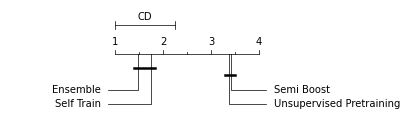

In [18]:
names = ["Self Train", "Semi Boost", "Ensemble", "Unsupervised Pretraining"]
cd = Orange.evaluation.compute_CD(avg_model_ranks, 14,alpha="0.05",test="nemenyi")
print("cd=",cd)

Orange.evaluation.graph_ranks(avg_model_ranks, names, cd=cd, width=5, textspace=1.5)
plt.show();

- Here <b>Self-Training</b> and <b>Ensemble</b> are <b>significantly better</b> than <b>Unsupervised Pretraining</b> and <b>Semi Boost</b><br>
- Ensemble performs the best overall
- There is <b>no critical difference</b> between <b>Self Training</b> and <b>Ensemble</b> as they perform the best<br>
- There is also <b>no critical difference</b> between <b>Unsupervised Pretraining</b> and <b>Semi Boost</b> who perform worse

## Comparing the Running Times of the Algorithms

In [64]:
time1 = pd.read_csv('data/time_ST.csv')
time1.set_index("Unnamed: 0",inplace=True)
time2 = pd.read_csv('data/time_Semi.csv')
time2.set_index("Unnamed: 0",inplace=True)
time3 = pd.read_csv('data/time_Ensemble.csv')
time3.set_index("Unnamed: 0",inplace=True)
time4 = pd.read_csv('data/time_UP.csv')
time4.set_index("Unnamed: 0",inplace=True)

time1.index.rename("Level",inplace=True)
time2.index.rename("Level",inplace=True)
time3.index.rename("Level",inplace=True)
time4.index.rename("Level",inplace=True)

In [66]:
final_time = pd.DataFrame(columns=["Self Training","Semi Boost","Ensemble","Unsupervised Pretraining"],index=list_index)

In [68]:
final_time["Self Training"] = list(time1['time_ST_D1'].append(time1['time_ST_D1_Over']).append(time1['time_ST_D1_Under']).append(time1['time_ST_D2']).append(time1['time_ST_D3']).reset_index(drop=True))
final_time["Semi Boost"] = list(time2['time_Semi_D1'].append(time2['time_Semi_D1_Over']).append(time2['time_Semi_D1_Under']).append(time2['time_Semi_D2']).append(time2['time_Semi_D3']).reset_index(drop=True))
final_time["Ensemble"] = list(time3['time_Ensemble_D1'].append(time3['time_Ensemble_D1_over']).append(time3['time_Ensemble_D1_under']).append(time3['time_Ensemble_D2']).append(time3['time_Ensemble_D3']).reset_index(drop=True))
final_time["Unsupervised Pretraining"] = list(time4['time_UP_D1'].append(time4['time_UP_D1_Over']).append(time4['time_UP_D1_Under']).append(time4['time_UP_D2']).append(time4['time_UP_D3']).reset_index(drop=True))

In [69]:
final_time

Self Training  Semi Boost    Ensemble  \
Dataset 1 0%              0.302734    0.366306   19.352713   
Dataset 1 10%             3.450545   32.201855  375.111397   
Dataset 1 20%             4.053230   34.615812  381.406955   
Dataset 1 50%             7.502557   36.959639  386.929944   
Dataset 1 90%             6.462972   40.193014  244.269760   
Dataset 1 95%             5.837992   37.810883  188.037271   
Dataset 1 Over 0%         0.630882    0.743571   35.094929   
Dataset 1 Over 10%        5.782788  278.431076  658.518475   
Dataset 1 Over 20%        8.566168  301.284895  752.366826   
Dataset 1 Over 50%       14.554686  271.218443  677.240970   
Dataset 1 Over 90%        6.206827  234.995912  469.272769   
Dataset 1 Over 95%        6.724198  242.700039  390.716610   
Dataset 1 Under 0%        0.192816    0.263066   10.453257   
Dataset 1 Under 10%       1.345742    4.991577  145.569318   
Dataset 1 Under 20%       2.036900    5.169866  162.133725   
Dataset 1 Under 50%       3.463071    5.572003  160.087989   
Dataset 1 Under 90%       1.965597    4.021419  123.348566   
Dataset 1 Under 95%       1.366496    3.960907  100.508274   
Dataset 2 0%              0.149328    0.132911    0.733790   
Dataset 2 10%             0.720685    1.533348    7.440661   
Dataset 2 20%             0.929489    1.749853    8.300540   
Dataset 2 50%             1.620258    1.947396    8.819817   
Dataset 2 90%             1.352235    1.848712    8.764851   
Dataset 2 95%             1.234914    1.667633    8.452470   
Dataset 3 0%              0.020489    0.013462    0.489175   
Dataset 3 10%             0.019273    0.033785    1.824702   
Dataset 3 20%             0.033939    0.040372    2.830980   
Dataset 3 50%             0.042697    0.050472    3.785737   
Dataset 3 90%             0.072998    0.064490    4.322583   
Dataset 3 95%             0.012651    0.061097    4.368736   

                     Unsupervised Pretraining  
Dataset 1 0%                        94.987409  
Dataset 1 10%                       92.236007  
Dataset 1 20%                       90.694356  
Dataset 1 50%                       73.892085  
Dataset 1 90%                       69.984207  
Dataset 1 95%                       83.568660  
Dataset 1 Over 0%                  183.005472  
Dataset 1 Over 10%                 176.992798  
Dataset 1 Over 20%                 171.349083  
Dataset 1 Over 50%                 154.072001  
Dataset 1 Over 90%                 114.192443  
Dataset 1 Over 95%                 113.682766  
Dataset 1 Under 0%                  46.153761  
Dataset 1 Under 10%                 45.565106  
Dataset 1 Under 20%                 40.152052  
Dataset 1 Under 50%                 37.466534  
Dataset 1 Under 90%                 42.589937  
Dataset 1 Under 95%                 42.593269  
Dataset 2 0%                        23.610177  
Dataset 2 10%                       22.497164  
Dataset 2 20%                       14.751992  
Dataset 2 50%                       22.191892  
Dataset 2 90%                       14.027507  
Dataset 2 95%                       13.994156  
Dataset 3 0%                         7.935666  
Dataset 3 10%                        8.033063  
Dataset 3 20%                        7.947203  
Dataset 3 50%                        7.974431  
Dataset 3 90%                        7.698036  
Dataset 3 95%                        7.577572

In [75]:
ranking = final_time.rank(axis=1,ascending=True)

In [76]:
avg_model_ranks = ranking.mean(axis=0)

### Friedman Test

In [73]:
friedmanchisquare(*[row for index, row in final_time.iterrows()])

FriedmanchisquareResult(statistic=104.53548387096777, pvalue=1.8164209155551077e-10)

For an Alpha of 0.05 the critical difference is <b>43.77</b>, therefore there is a significant difference between the runtimes of the algorithms

### Nemenyi Post-hoc Test

cd= 1.2535592581035582


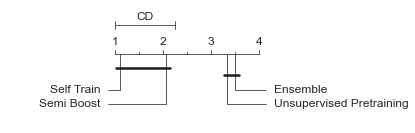

In [77]:
names = ["Self Train", "Semi Boost", "Ensemble", "Unsupervised Pretraining"]
cd = Orange.evaluation.compute_CD(avg_model_ranks, 14,alpha="0.05",test="nemenyi")
print("cd=",cd)

Orange.evaluation.graph_ranks(avg_model_ranks, names, cd=cd, width=5, textspace=1.5)
plt.show();

## Best Algorithm Dataset Pairs

In [59]:
final

Self Training  Semi Boost  Ensemble  \
Dataset 1 0%              0.625743    0.625743  0.619850   
Dataset 1 10%             0.626104    0.598921  0.624765   
Dataset 1 20%             0.610611    0.591156  0.629490   
Dataset 1 50%             0.596349    0.352068  0.606607   
Dataset 1 90%             0.509849    0.266414  0.548422   
Dataset 1 95%             0.435424    0.267672  0.554371   
Dataset 1 Over 0%         0.642682    0.642682  0.644148   
Dataset 1 Over 10%        0.658517    0.612216  0.638953   
Dataset 1 Over 20%        0.645367    0.497169  0.649731   
Dataset 1 Over 50%        0.647719    0.269139  0.649808   
Dataset 1 Over 90%        0.635724    0.267853  0.637978   
Dataset 1 Over 95%        0.624055    0.267853  0.631130   
Dataset 1 Under 0%        0.630284    0.630284  0.649068   
Dataset 1 Under 10%       0.649533    0.609097  0.639938   
Dataset 1 Under 20%       0.634921    0.502834  0.649027   
Dataset 1 Under 50%       0.657935    0.274424  0.644911   
Dataset 1 Under 90%       0.620451    0.267853  0.613730   
Dataset 1 Under 95%       0.625839    0.267853  0.610727   
Dataset 2 0%              0.886191    0.886191  0.900602   
Dataset 2 10%             0.905263    0.878698  0.895706   
Dataset 2 20%             0.879389    0.860367  0.889908   
Dataset 2 50%             0.862500    0.732203  0.888550   
Dataset 2 90%             0.822981    0.654582  0.852410   
Dataset 2 95%             0.803625    0.653924  0.846154   
Dataset 3 0%              0.831683    0.831683  0.834951   
Dataset 3 10%             0.831683    0.854369  0.857143   
Dataset 3 20%             0.843137    0.841121  0.834951   
Dataset 3 50%             0.878505    0.761905  0.867925   
Dataset 3 90%             0.857143    0.709220  0.795918   
Dataset 3 95%             0.807692    0.709220  0.787234   

                     Unsupervised Pretraining  
Dataset 1 0%                         0.572641  
Dataset 1 10%                        0.557127  
Dataset 1 20%                        0.564935  
Dataset 1 50%                        0.557734  
Dataset 1 90%                        0.488323  
Dataset 1 95%                        0.494929  
Dataset 1 Over 0%                    0.580508  
Dataset 1 Over 10%                   0.585643  
Dataset 1 Over 20%                   0.587986  
Dataset 1 Over 50%                   0.596017  
Dataset 1 Over 90%                   0.522285  
Dataset 1 Over 95%                   0.523227  
Dataset 1 Under 0%                   0.609325  
Dataset 1 Under 10%                  0.609463  
Dataset 1 Under 20%                  0.613690  
Dataset 1 Under 50%                  0.619647  
Dataset 1 Under 90%                  0.586667  
Dataset 1 Under 95%                  0.538231  
Dataset 2 0%                         0.871795  
Dataset 2 10%                        0.870091  
Dataset 2 20%                        0.858447  
Dataset 2 50%                        0.848120  
Dataset 2 90%                        0.750000  
Dataset 2 95%                        0.692063  
Dataset 3 0%                         0.810345  
Dataset 3 10%                        0.827586  
Dataset 3 20%                        0.827586  
Dataset 3 50%                        0.796610  
Dataset 3 90%                        0.742424  
Dataset 3 95%                        0.769231

In [60]:
ranking = final.rank(axis=1,ascending=False)

In [61]:
ranking

Self Training  Semi Boost  Ensemble  \
Dataset 1 0%                   1.5         1.5       3.0   
Dataset 1 10%                  1.0         3.0       2.0   
Dataset 1 20%                  2.0         3.0       1.0   
Dataset 1 50%                  2.0         4.0       1.0   
Dataset 1 90%                  2.0         4.0       1.0   
Dataset 1 95%                  3.0         4.0       1.0   
Dataset 1 Over 0%              2.5         2.5       1.0   
Dataset 1 Over 10%             1.0         3.0       2.0   
Dataset 1 Over 20%             2.0         4.0       1.0   
Dataset 1 Over 50%             2.0         4.0       1.0   
Dataset 1 Over 90%             2.0         4.0       1.0   
Dataset 1 Over 95%             2.0         4.0       1.0   
Dataset 1 Under 0%             2.5         2.5       1.0   
Dataset 1 Under 10%            1.0         4.0       2.0   
Dataset 1 Under 20%            2.0         4.0       1.0   
Dataset 1 Under 50%            1.0         4.0       2.0   
Dataset 1 Under 90%            1.0         4.0       2.0   
Dataset 1 Under 95%            1.0         4.0       2.0   
Dataset 2 0%                   2.5         2.5       1.0   
Dataset 2 10%                  1.0         3.0       2.0   
Dataset 2 20%                  2.0         3.0       1.0   
Dataset 2 50%                  2.0         4.0       1.0   
Dataset 2 90%                  2.0         4.0       1.0   
Dataset 2 95%                  2.0         4.0       1.0   
Dataset 3 0%                   2.5         2.5       1.0   
Dataset 3 10%                  3.0         2.0       1.0   
Dataset 3 20%                  1.0         2.0       3.0   
Dataset 3 50%                  1.0         4.0       2.0   
Dataset 3 90%                  1.0         4.0       2.0   
Dataset 3 95%                  1.0         4.0       2.0   

                     Unsupervised Pretraining  
Dataset 1 0%                              4.0  
Dataset 1 10%                             4.0  
Dataset 1 20%                             4.0  
Dataset 1 50%                             3.0  
Dataset 1 90%                             3.0  
Dataset 1 95%                             2.0  
Dataset 1 Over 0%                         4.0  
Dataset 1 Over 10%                        4.0  
Dataset 1 Over 20%                        3.0  
Dataset 1 Over 50%                        3.0  
Dataset 1 Over 90%                        3.0  
Dataset 1 Over 95%                        3.0  
Dataset 1 Under 0%                        4.0  
Dataset 1 Under 10%                       3.0  
Dataset 1 Under 20%                       3.0  
Dataset 1 Under 50%                       3.0  
Dataset 1 Under 90%                       3.0  
Dataset 1 Under 95%                       3.0  
Dataset 2 0%                              4.0  
Dataset 2 10%                             4.0  
Dataset 2 20%                             4.0  
Dataset 2 50%                             3.0  
Dataset 2 90%                             3.0  
Dataset 2 95%                             3.0  
Dataset 3 0%                              4.0  
Dataset 3 10%                             4.0  
Dataset 3 20%                             4.0  
Dataset 3 50%                             3.0  
Dataset 3 90%                             3.0  
Dataset 3 95%                             3.0

- For Dataset 1 the Semi supervised <b>Ensemble</b> is the best performing algorithm when it is unbalanced and over-sampled
- When Dataset 1 is Under-sampled, <b>Self Training</b> is the best
- For Dataset 2 the Semi supervised <b>Ensemble</b> is the best performing algorithm
- For Dataset 3 the Semi supervised <b>Ensemble</b> is the best performing algorithm

### Impact of Label Percentage and Skew on Dataset 1 for the Ensemble SSL

In [62]:
unbalanced = list(final.iloc[0:6,2])
over_sampled = list(final.iloc[6:12,2])
under_sampled = list(final.iloc[12:18,2])

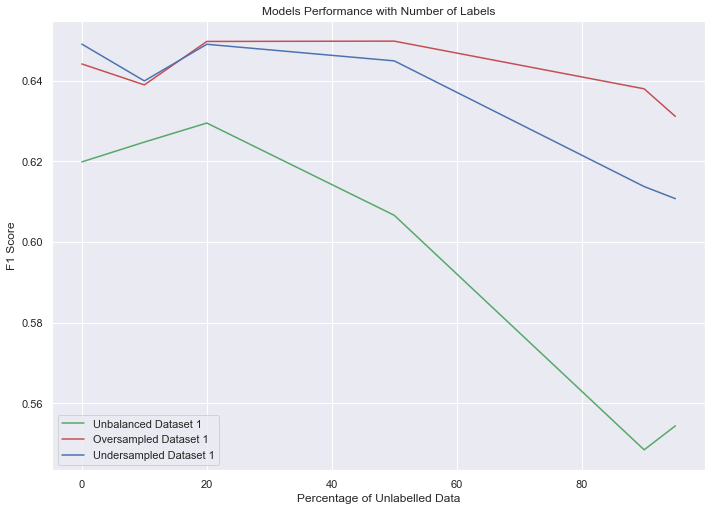

In [63]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
epochs = [0,10,20,50,90,95]
plt.plot(epochs, unbalanced, 'g', label='Unbalanced Dataset 1')
plt.plot(epochs, over_sampled, 'r', label='Oversampled Dataset 1')
plt.plot(epochs, under_sampled, 'b', label='Undersampled Dataset 1')
plt.title('Models Performance with Number of Labels')
plt.xlabel('Percentage of Unlabelled Data')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

### Impact of Label Percentage on Dataset 2 for the Ensemble SSL

In [65]:
data2 = list(final.iloc[18:24,2])

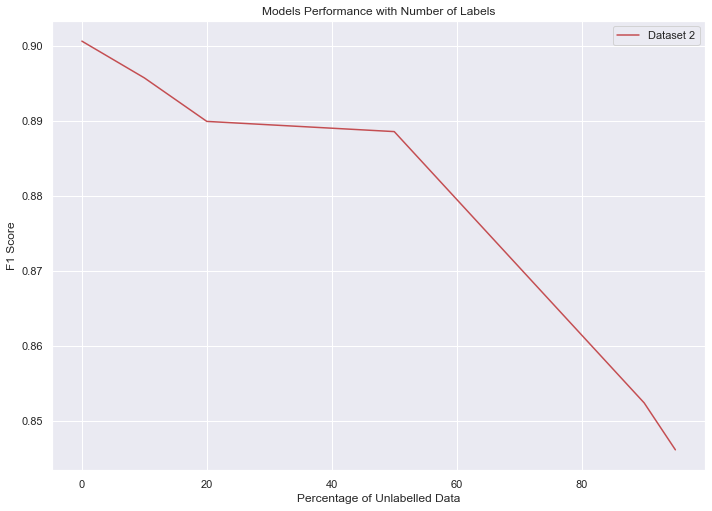

In [66]:
epochs = [0,10,20,50,90,95]
plt.plot(epochs, data2, 'r', label='Dataset 2')
plt.title('Models Performance with Number of Labels')
plt.xlabel('Percentage of Unlabelled Data')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

### Impact of Label Percentage on Dataset 3 for Self-Training

In [69]:
data3 = list(final.iloc[24:30,0])

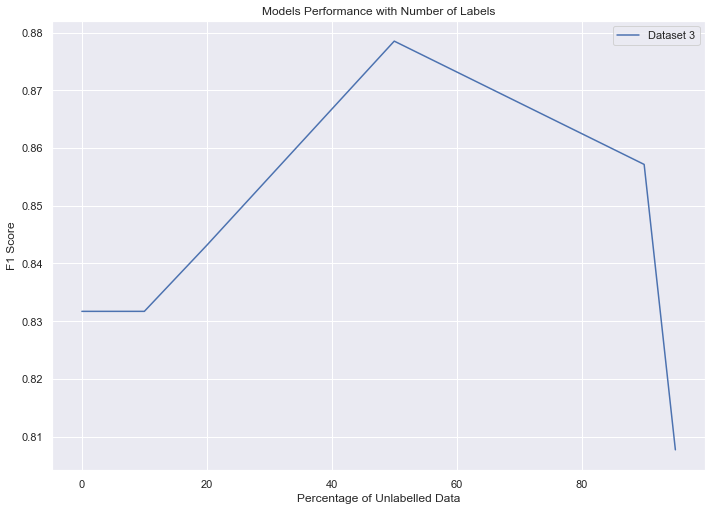

In [70]:
epochs = [0,10,20,50,90,95]
plt.plot(epochs, data3, 'b', label='Dataset 3')
plt.title('Models Performance with Number of Labels')
plt.xlabel('Percentage of Unlabelled Data')
plt.ylabel('F1 Score')
plt.legend()
plt.show()